# Application of pyKAN for 1D VLBI Data Interpolation

## Introduction

Introduction goes here.

## Imports

In [1]:
import torch
import numpy as np
import pandas as pd
from kan import *
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings

# precoded functions from supplementary modules
from data_preparation import *
from data_visualization import *

## Globals and Settings

In [2]:
# ignore warnings
warnings.filterwarnings(action="ignore")

In [3]:
# initialize torch device as `gpu` if exists else `cpu`
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using `{device}` device for torch.")

Using `cpu` device for torch.


In [4]:
DATASET_FILE = '.\data\Cres_05.txt'

In [5]:
TEST_SIZE = 0.3

In [6]:
# random seed global variable
RANDOM_STATE = 42

# Crest Model Dataset

## Data Loading

In [7]:
# load data from text file indicated in DATASET_FILE global variable
dataset = pd.read_csv(DATASET_FILE, sep='\t')

In [8]:
# general information about dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259200 entries, 0 to 259199
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   U       259200 non-null  float64
 1   V       259200 non-null  float64
 2   Re      259200 non-null  float64
 3   Im      259200 non-null  float64
dtypes: float64(4)
memory usage: 7.9 MB


## EDA

In [9]:
# calculate visibility amplitude and phase and add it to initial dataset
calculate_baseline_amplitude(dataset=dataset, inplace=True, sort_baselines=True)

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259200 entries, 0 to 259199
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   U          259200 non-null  float64
 1   V          259200 non-null  float64
 2   Re         259200 non-null  float64
 3   Im         259200 non-null  float64
 4   Baseline   259200 non-null  float64
 5   Amplitude  259200 non-null  float64
 6   Phase      259200 non-null  float64
dtypes: float64(7)
memory usage: 13.8 MB


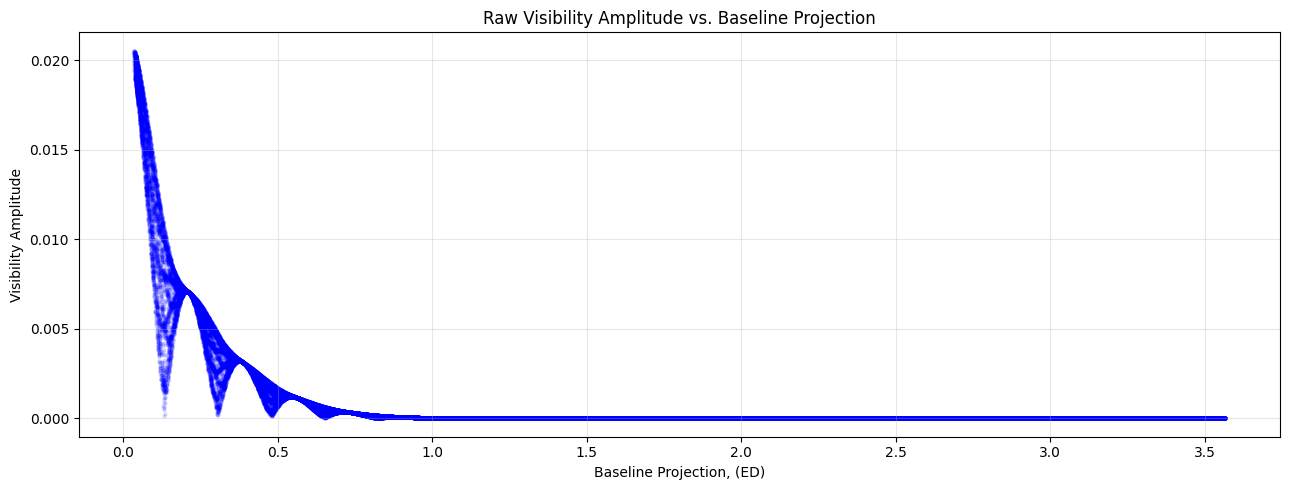

In [11]:
plot_scatter(x=dataset['Baseline'],
             y=dataset['Amplitude'],
             xlabel='Baseline Projection, (ED)',
             ylabel='Visibility Amplitude',
             title='Raw Visibility Amplitude vs. Baseline Projection',
             grid=True,
             figsize=(13, 5)
             )

In [12]:
# extract visibility amplitude along the cross-section
delta_test = 0.01
alpha_test = 45

filtered_data, mask, distance = cross_section(dataset, 
                                              delta=delta_test, 
                                              alpha_deg=alpha_test)

Angle: 45, (deg.)
Cross-section width: 0.01
Number of points: 1603/259200 (0.6%)


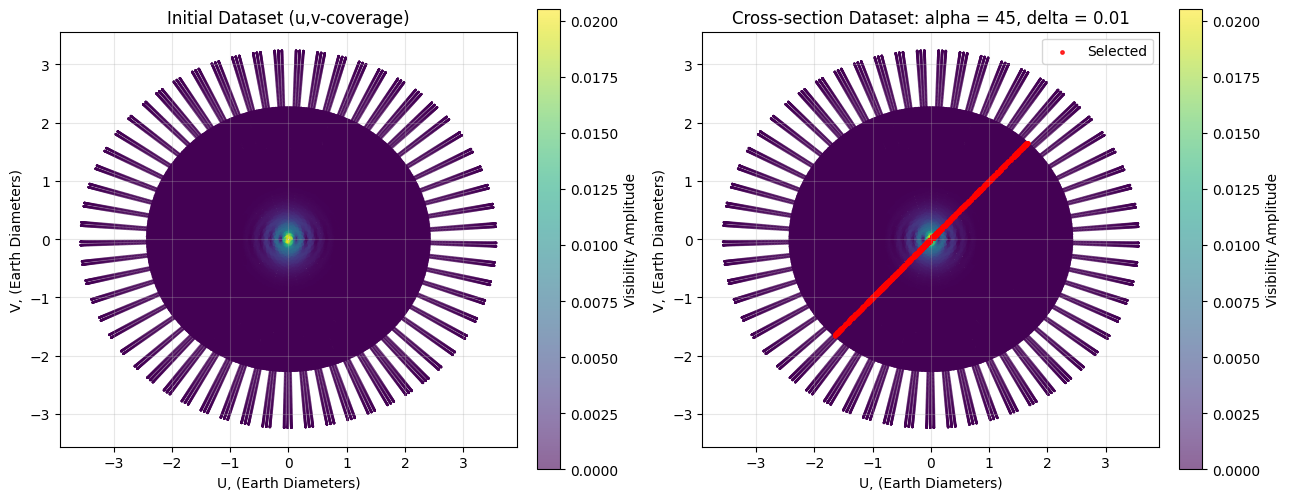

In [13]:
plot_uv_coverage(
    dataset=dataset,
    alpha_test=alpha_test,
    delta_test=delta_test,
    amplitude_col='Amplitude',
    u_col='U',
    v_col='V',
    figsize=(13, 6),
    point_size=3,
    alpha_val=0.6,
    cmap='viridis',
    selected_color='red'
);

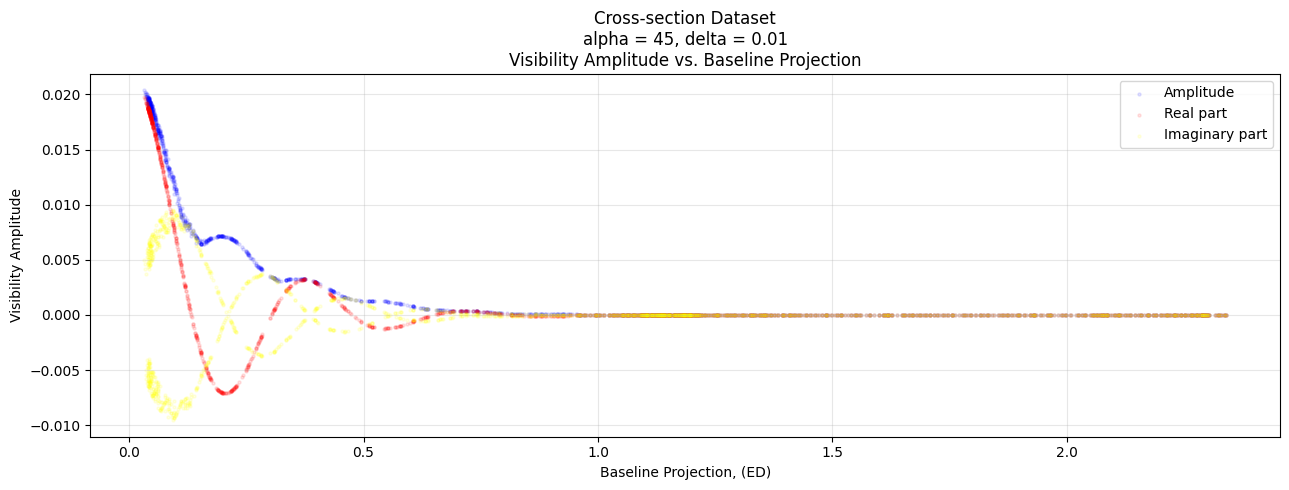

In [14]:
plot_visibility_components(
    filtered_data=filtered_data,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    real_col='Re',
    imag_col='Im',
    alpha=0.1,
    size=5,
    amplitude_color='blue',
    real_color='red',
    imag_color='yellow',
    figsize=(13, 5),
    xlabel='Baseline Projection, (ED)',
    ylabel='Visibility Amplitude',
    title_prefix='Cross-section Dataset',
    alpha_test=alpha_test,
    delta_test=delta_test,
    grid=True
);

## Data Prepartion

In [15]:
selected_data, rest_data, used_ranges = select_by_baseline_ranges(
    dataset=filtered_data,
    baseline_col='Baseline',
    ranges=[(0.1, 0.2), (0.5, 0.6), (0.7, 0.8)],
    mode='specified'
)

Mode: specified
Selected baseline ranges: [(0.1, 0.2), (0.5, 0.6), (0.7, 0.8)]
Points selected: 223 from 1,603 (13.9%)
Selected range sizes: [0.1, 0.09999999999999998, 0.10000000000000009]


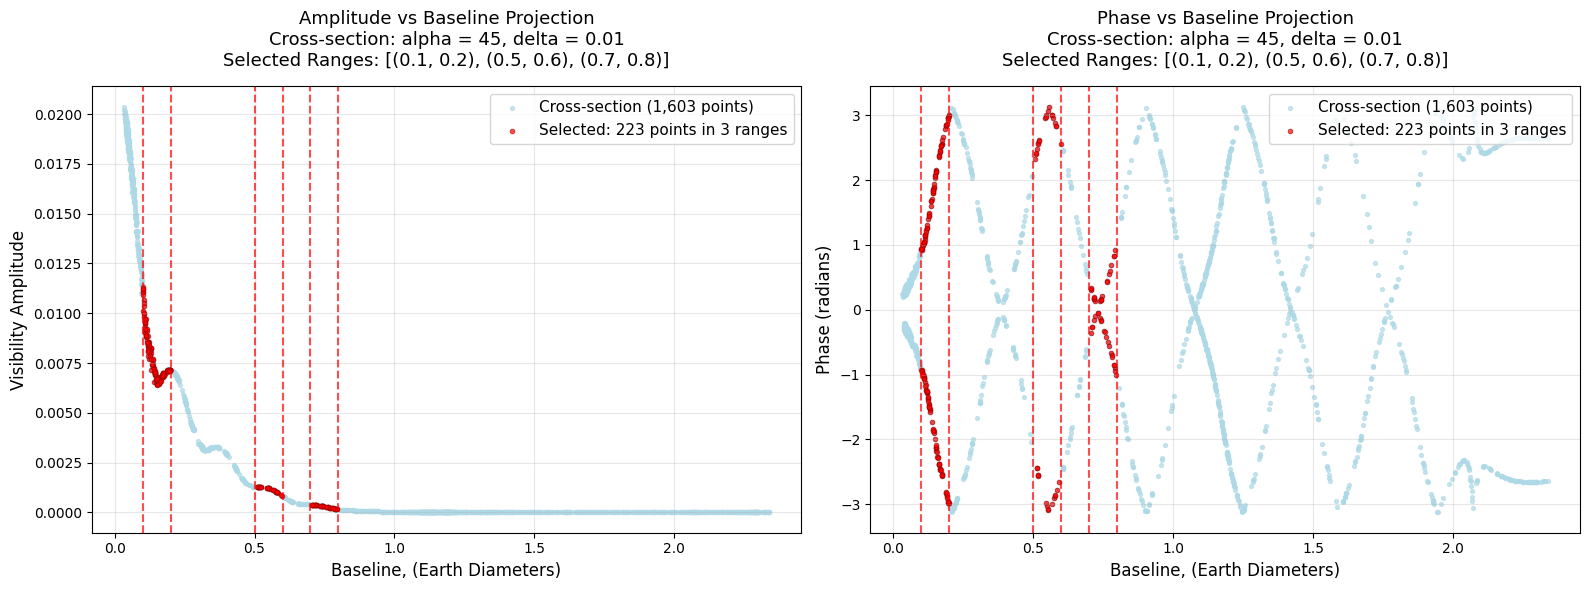

In [16]:
plot_amplitude_phase_with_selection(
    filtered_data, selected_data, used_ranges,
    alpha_test=alpha_test, delta_test=delta_test
);

**Comment**: next step is to prepare the dataset for further training, validation and testing of the model.

In [17]:
rest_data = rest_data.sort_values('Baseline').reset_index(drop=True)

X_data = rest_data[['U', 'V', 'Baseline']].values
y_data = rest_data[['Re', 'Im']].values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_data)

X_tensor = torch.from_numpy(X_scaled).float()
y_tensor = torch.from_numpy(y_scaled).float()

In [18]:
# creating initial dataset
dataset_model = create_dataset_from_data(X_tensor, y_tensor, train_ratio=1-TEST_SIZE, device=device)

In [19]:
print("Training dataset input features dimensions:", dataset_model['train_input'].shape)
print("Training dataset target features dimensions:", dataset_model['train_label'].shape)
print("Validation dataset input features dimensions:", dataset_model['test_input'].shape)
print("Validation dataset target features dimensions:", dataset_model['test_label'].shape)

Training dataset input features dimensions: torch.Size([965, 3])
Training dataset target features dimensions: torch.Size([965, 2])
Validation dataset input features dimensions: torch.Size([415, 3])
Validation dataset target features dimensions: torch.Size([415, 2])


## Model Initialization

In [20]:
# initialize model
model = KAN(width=[3, 12, 12, 2],
            grid=5,
            k=3,
            seed=RANDOM_STATE,
            device=device)


checkpoint directory created: ./model
saving model version 0.0


## Training

In [21]:
history = model.fit(dataset_model,
                    opt="LBFGS",
                    steps=1000,
                    update_grid=True);

| train_loss: 2.13e-03 | test_loss: 3.48e-03 | reg: 6.12e+01 | : 100%|█| 1000/1000 [09:05<00:00,  1.

saving model version 0.1


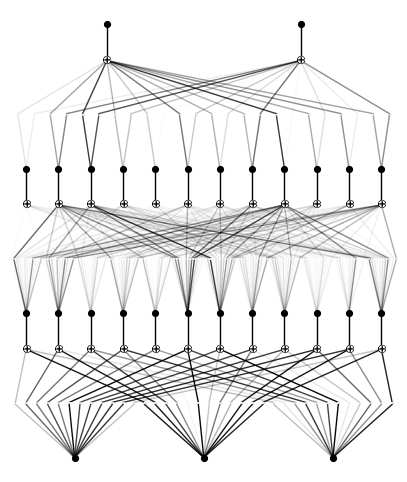

In [22]:
model.plot()

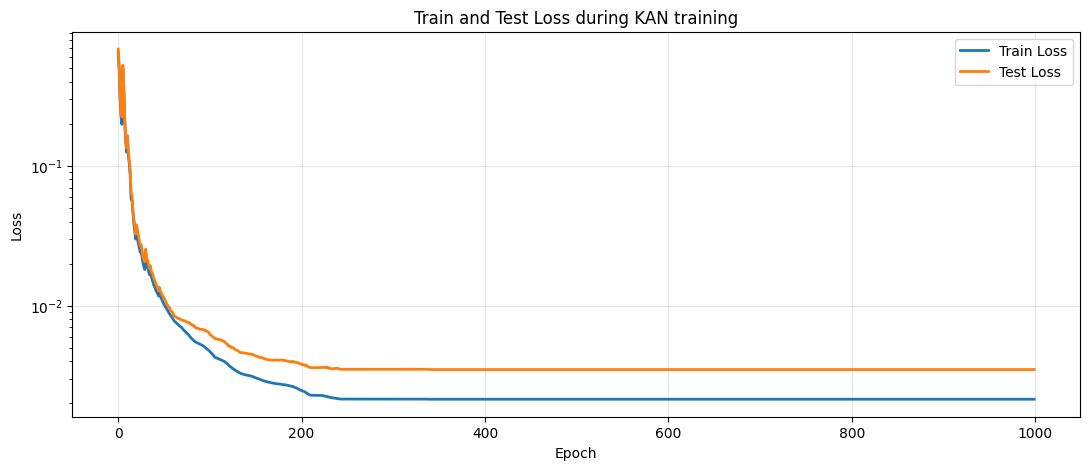

In [23]:
plt.figure(figsize=(13, 5))
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss during KAN training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

## Testing

### Selected Ranges

In [24]:
test_data_raw = selected_data[['U', 'V', 'Baseline']].values
test_data_scaled = scaler_X.transform(test_data_raw)
test_data = torch.from_numpy(test_data_scaled).float()

In [25]:
results_scaled = model(test_data)

In [26]:
results_denormalized = scaler_y.inverse_transform(results_scaled.detach().numpy())
results_amplitude = np.sqrt(results_denormalized[:, 0]**2 + results_denormalized[:, 1]**2)
results_phase = np.arctan2(results_denormalized[:, 1], results_denormalized[:, 0])

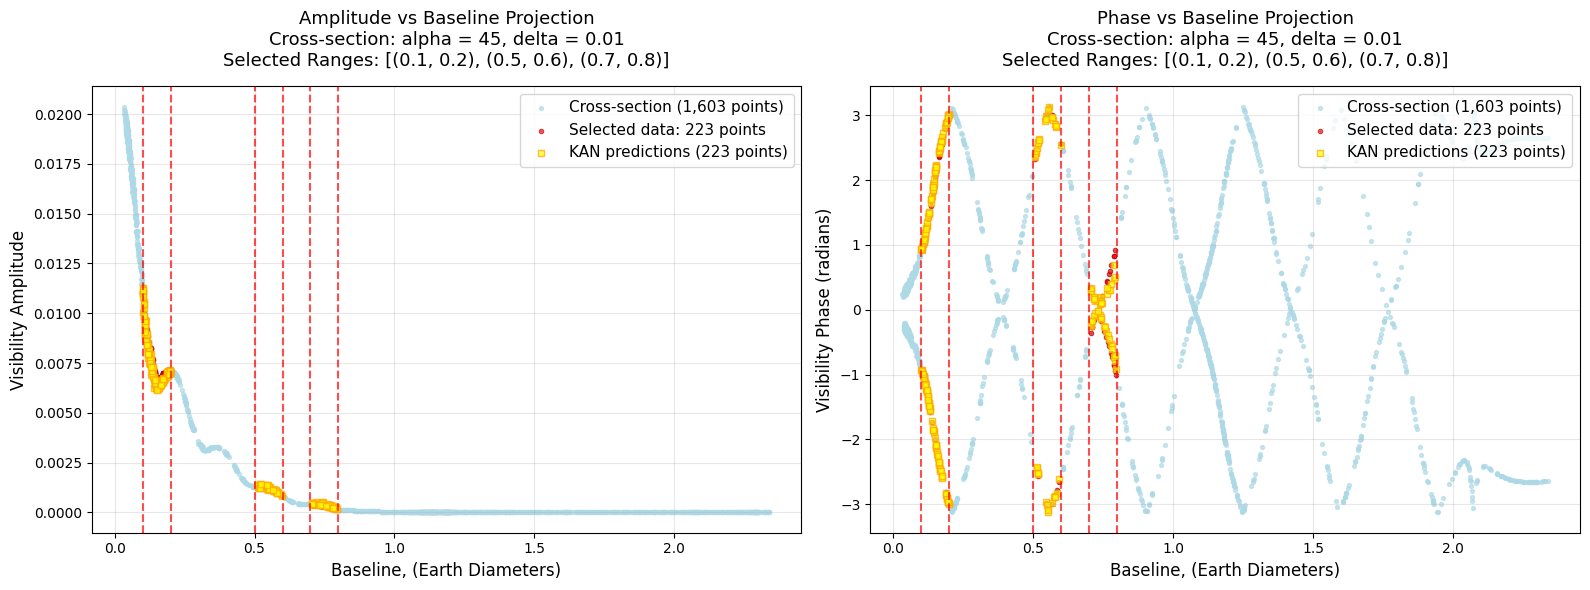

In [27]:
fig, axs = plot_predictions_comparison(
    filtered_data, selected_data, results_amplitude, results_phase, used_ranges,
    alpha_test=alpha_test, delta_test=delta_test
)

### Whole Dataset

In [28]:
whole_data_raw = filtered_data[['U', 'V', 'Baseline']].values
whole_data_scaled = scaler_X.transform(whole_data_raw)
whole_data = torch.from_numpy(whole_data_scaled).float()

In [29]:
results_whole_scaled = model(whole_data)

In [30]:
results_whole_denormalized = scaler_y.inverse_transform(results_whole_scaled.detach().numpy())
results_whole = np.sqrt(results_whole_denormalized[:, 0]**2 + results_whole_denormalized[:, 1]**2)
results_phase_whole = np.arctan2(results_whole_denormalized[:, 1], results_whole_denormalized[:, 0])

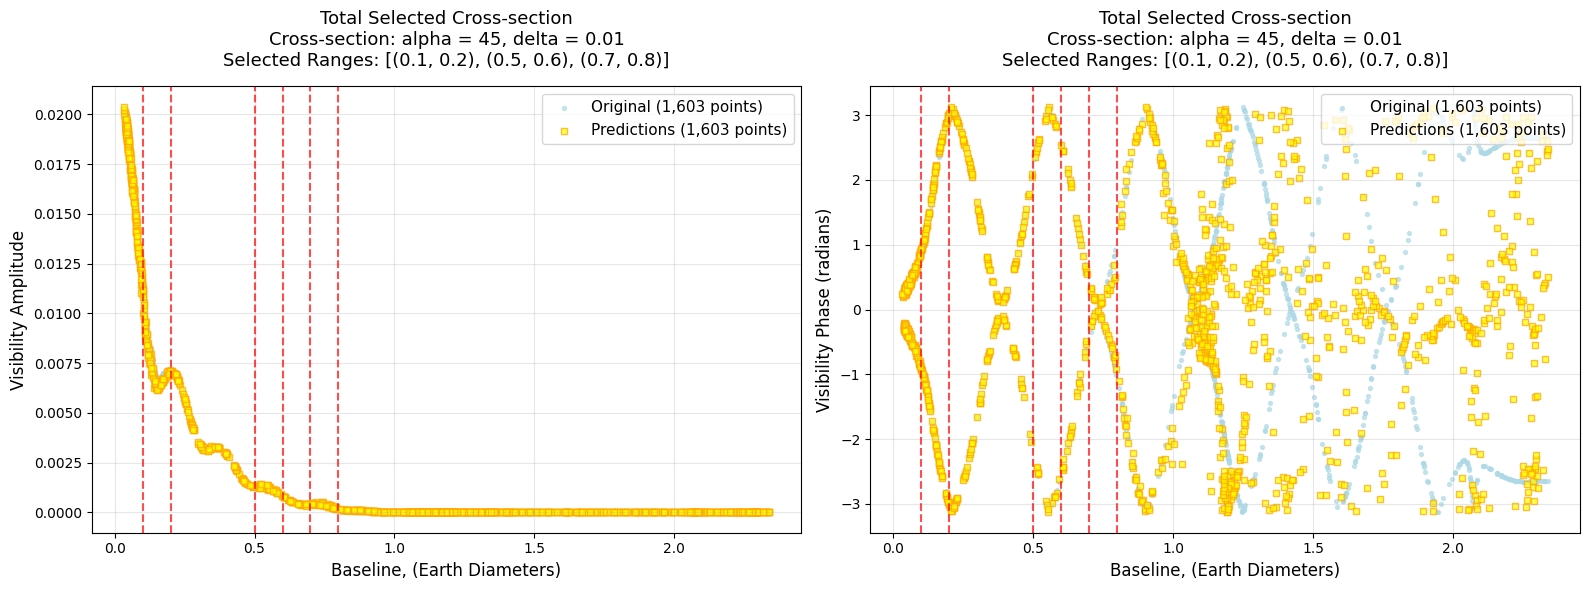

In [31]:
fig, axs = plot_whole_predictions(
    filtered_data, results_whole, results_phase_whole, used_ranges,
    alpha_test=alpha_test, delta_test=delta_test
)

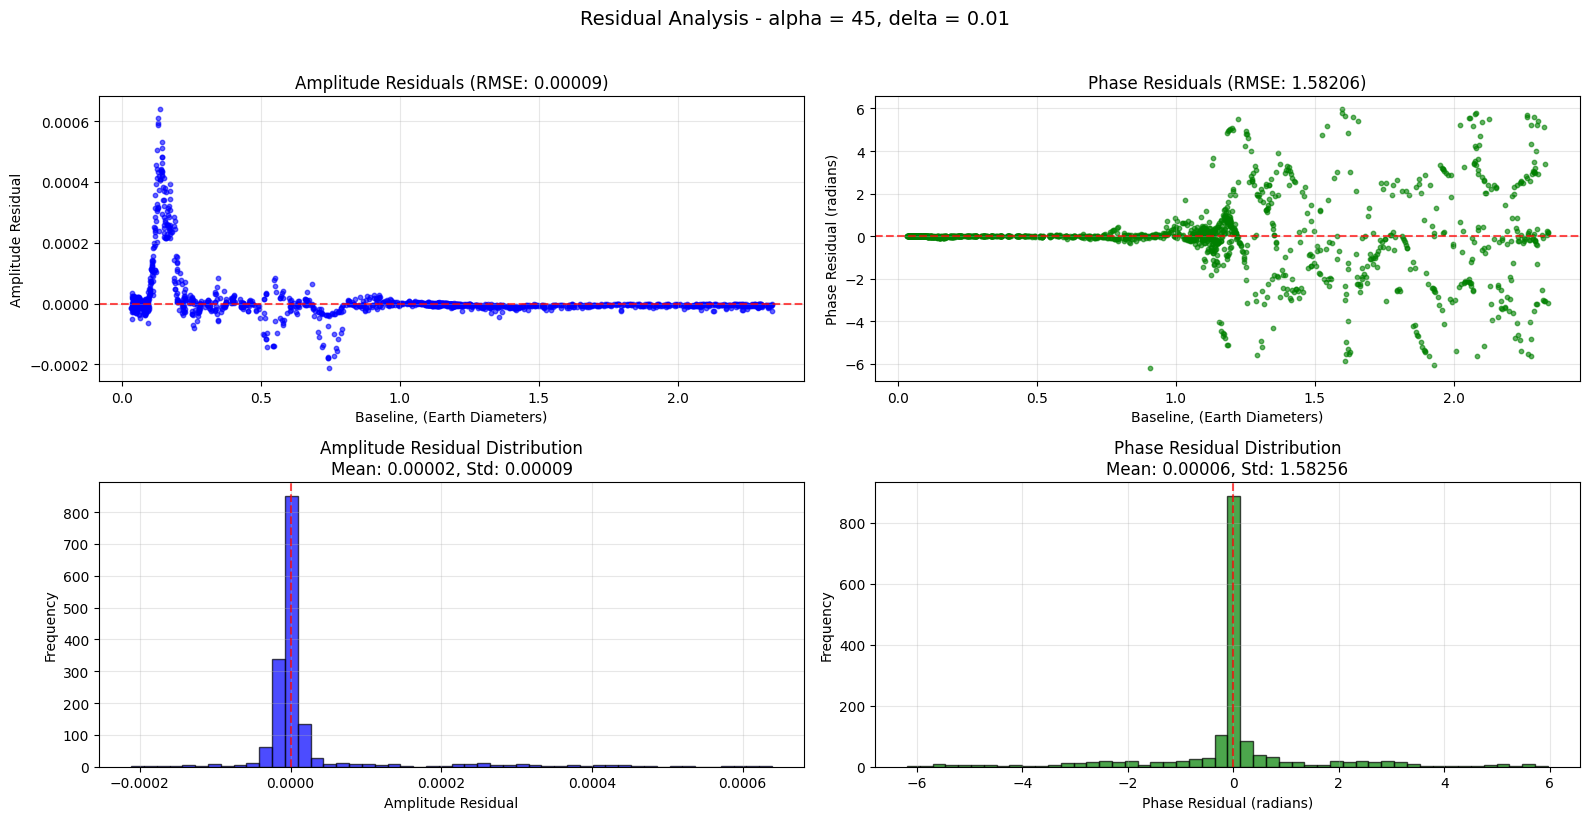

Residuals statistics:

Amplitude:
- RMSE: 0.00009
- MAE: 0.00003
- Mean residual: 0.00002
- Std residual: 0.00009

Phase:
- RMSE: 1.58206
- MAE: 0.78868
- Mean residual: 0.00006
- Std residual: 1.58256


In [32]:
fig, stats = plot_residuals_analysis(
    filtered_data=filtered_data,
    results_amplitude=results_whole,
    results_phase=results_phase_whole,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    phase_col='Phase',
    alpha_test=alpha_test,
    delta_test=delta_test,
    figsize=(16, 8),
    return_stats=True
)

## Results and Discussions

# Crest Model Dataset (Noise Injection 10%)

## Noise Injection

In [33]:
filtered_data_noisy = add_noise(filtered_data, 
                                re_noise_percent=10, 
                                im_noise_percent=10, 
                                random_seed=RANDOM_STATE)

# calculate visibility amplitude and phase and add it to initial dataset
calculate_baseline_amplitude(dataset=filtered_data_noisy, inplace=True, sort_baselines=True)

## EDA

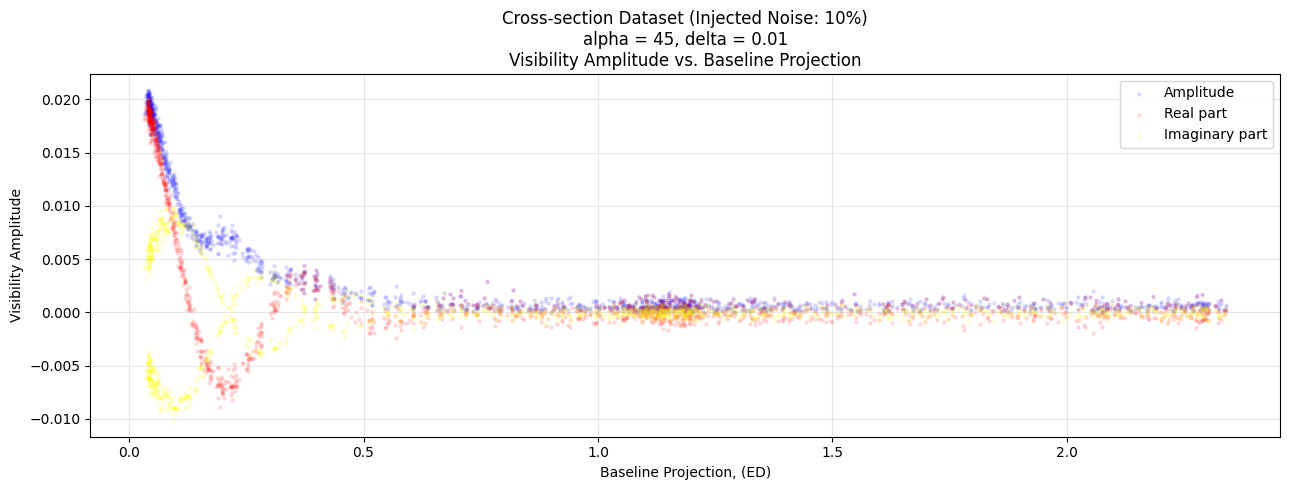

In [34]:
plot_visibility_components(
    filtered_data=filtered_data_noisy,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    real_col='Re',
    imag_col='Im',
    alpha=0.1,
    size=5,
    amplitude_color='blue',
    real_color='red',
    imag_color='yellow',
    figsize=(13, 5),
    xlabel='Baseline Projection, (ED)',
    ylabel='Visibility Amplitude',
    title_prefix='Cross-section Dataset (Injected Noise: 10%)',
    alpha_test=alpha_test,
    delta_test=delta_test,
    grid=True
);

## Data Preparation

In [35]:
selected_data_noisy, rest_data_noisy, used_ranges = select_by_baseline_ranges(dataset=filtered_data_noisy,
                                                                  baseline_col='Baseline',
                                                                  ranges=[(0.1, 0.2), (0.5, 0.6), (0.7, 0.8)],
                                                                  mode='specified'
                                                                  )

Mode: specified
Selected baseline ranges: [(0.1, 0.2), (0.5, 0.6), (0.7, 0.8)]
Points selected: 223 from 1,603 (13.9%)
Selected range sizes: [0.1, 0.09999999999999998, 0.10000000000000009]


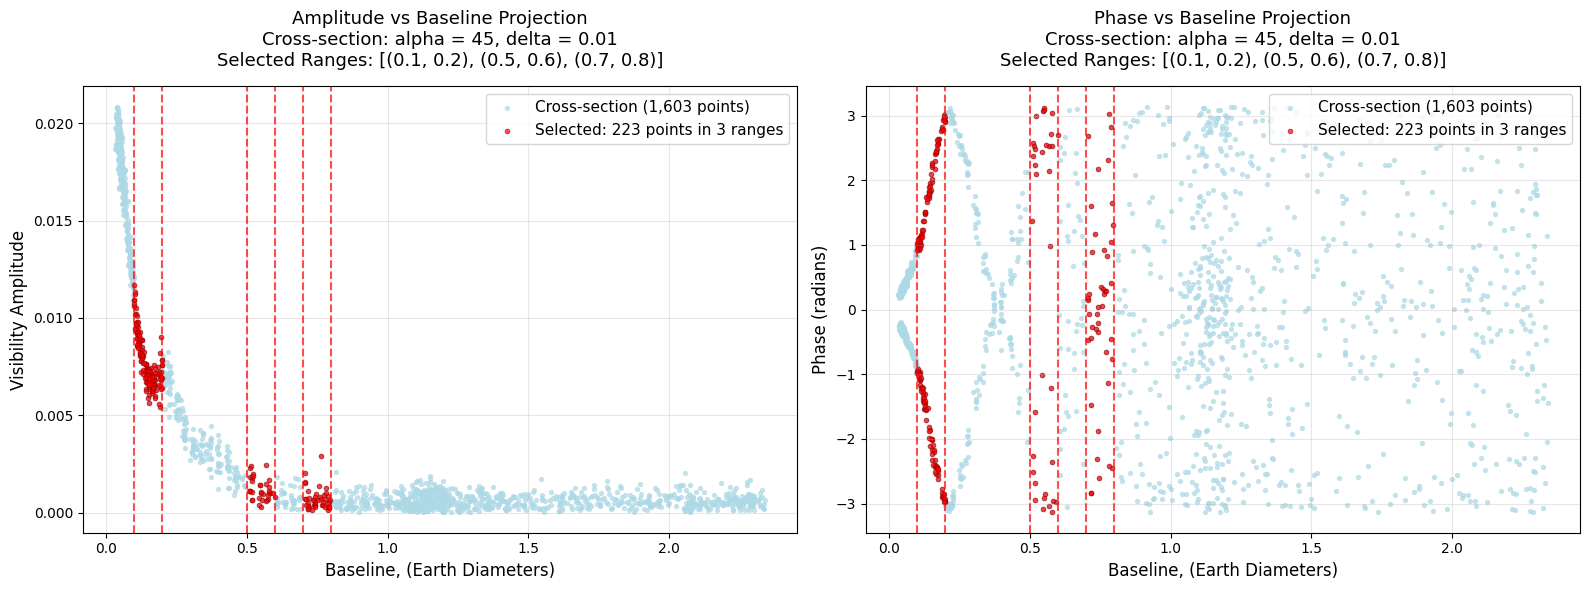

In [36]:
plot_amplitude_phase_with_selection(filtered_data_noisy, selected_data_noisy, used_ranges,
                                    alpha_test=alpha_test, delta_test=delta_test);

In [37]:
rest_data_noisy = rest_data_noisy.sort_values('Baseline').reset_index(drop=True)

X_data = rest_data_noisy[['U', 'V', 'Baseline']].values
y_data = rest_data_noisy[['Re', 'Im']].values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_data)

X_tensor = torch.from_numpy(X_scaled).float()
y_tensor = torch.from_numpy(y_scaled).float()

In [38]:
# creating initial dataset
dataset_noisy = create_dataset_from_data(X_tensor, y_tensor, train_ratio=1-TEST_SIZE, device=device)

In [39]:
# initialize model
model_noisy = KAN(width=[3, 12, 12, 2],
            grid=5,
            k=3,
            seed=RANDOM_STATE,
            device=device)

checkpoint directory created: ./model
saving model version 0.0


## Training

In [40]:
history_noisy = model_noisy.fit(dataset_noisy,
                            opt="LBFGS",
                            steps=1000,
                            update_grid=True);

| train_loss: 9.48e-02 | test_loss: 1.08e-01 | reg: 6.01e+01 | : 100%|█| 1000/1000 [11:25<00:00,  1.

saving model version 0.1


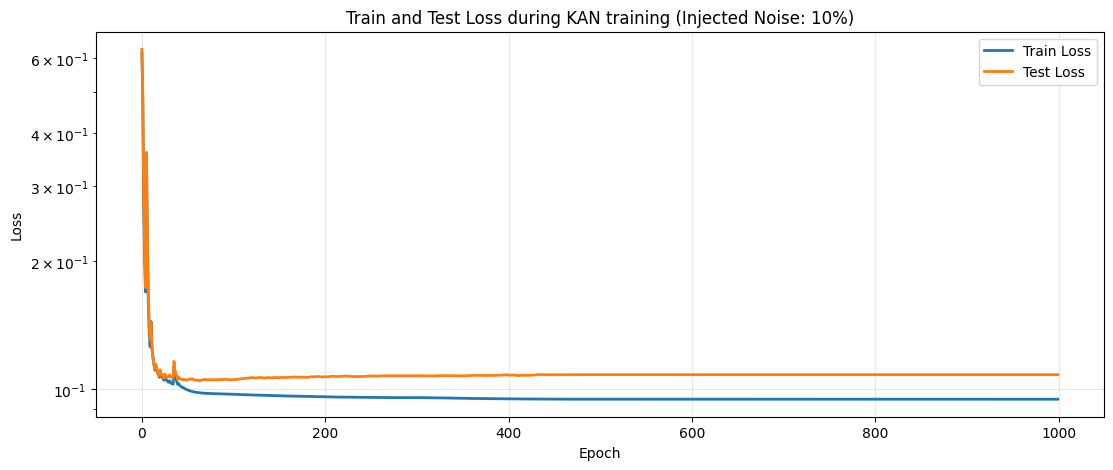

In [41]:
plt.figure(figsize=(13, 5))
plt.plot(history_noisy['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history_noisy['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss during KAN training (Injected Noise: 10%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

## Testing

### Selected Ranges

In [42]:
test_data_raw = selected_data_noisy[['U', 'V', 'Baseline']].values
test_data_scaled = scaler_X.transform(test_data_raw)
test_data = torch.from_numpy(test_data_scaled).float()

In [43]:
results_scaled = model(test_data)

In [44]:
results_denormalized = scaler_y.inverse_transform(results_scaled.detach().numpy())
results_amplitude_noisy = np.sqrt(results_denormalized[:, 0]**2 + results_denormalized[:, 1]**2)
results_phase_noisy = np.atan2(results_denormalized[:, 1], results_denormalized[:, 0])

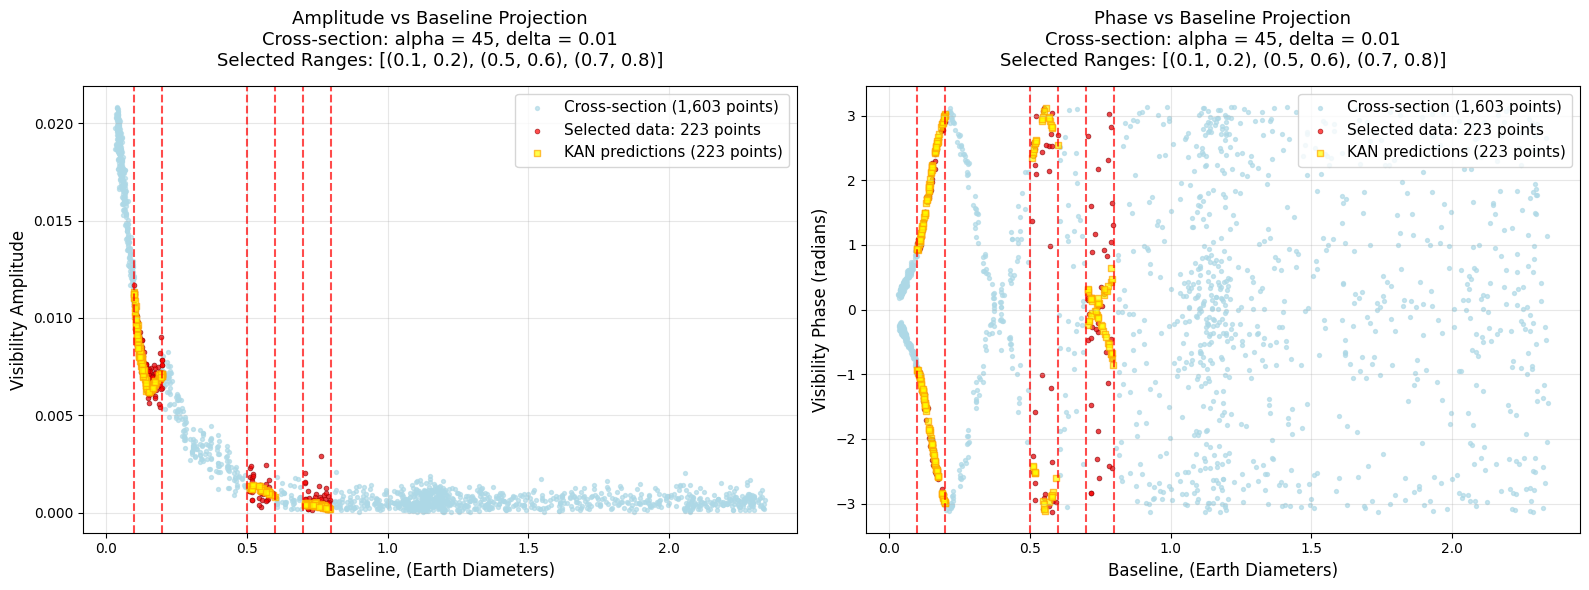

In [45]:
fig, axs = plot_predictions_comparison(filtered_data_noisy, selected_data_noisy, results_amplitude_noisy, 
                                       results_phase_noisy, used_ranges,
                                       alpha_test=alpha_test, delta_test=delta_test)

### Whole Dataset

In [46]:
whole_data_raw = filtered_data_noisy[['U', 'V', 'Baseline']].values
whole_data_scaled = scaler_X.transform(whole_data_raw)
whole_data = torch.from_numpy(whole_data_scaled).float()

In [47]:
results_whole_scaled = model(whole_data)

In [48]:
results_whole_denormalized = scaler_y.inverse_transform(results_whole_scaled.detach().numpy())
results_amplitude_whole_noisy = np.sqrt(results_whole_denormalized[:, 0]**2 + results_whole_denormalized[:, 1]**2)
results_phase_whole_noisy = np.atan2(results_whole_denormalized[:, 1], results_whole_denormalized[:, 0])

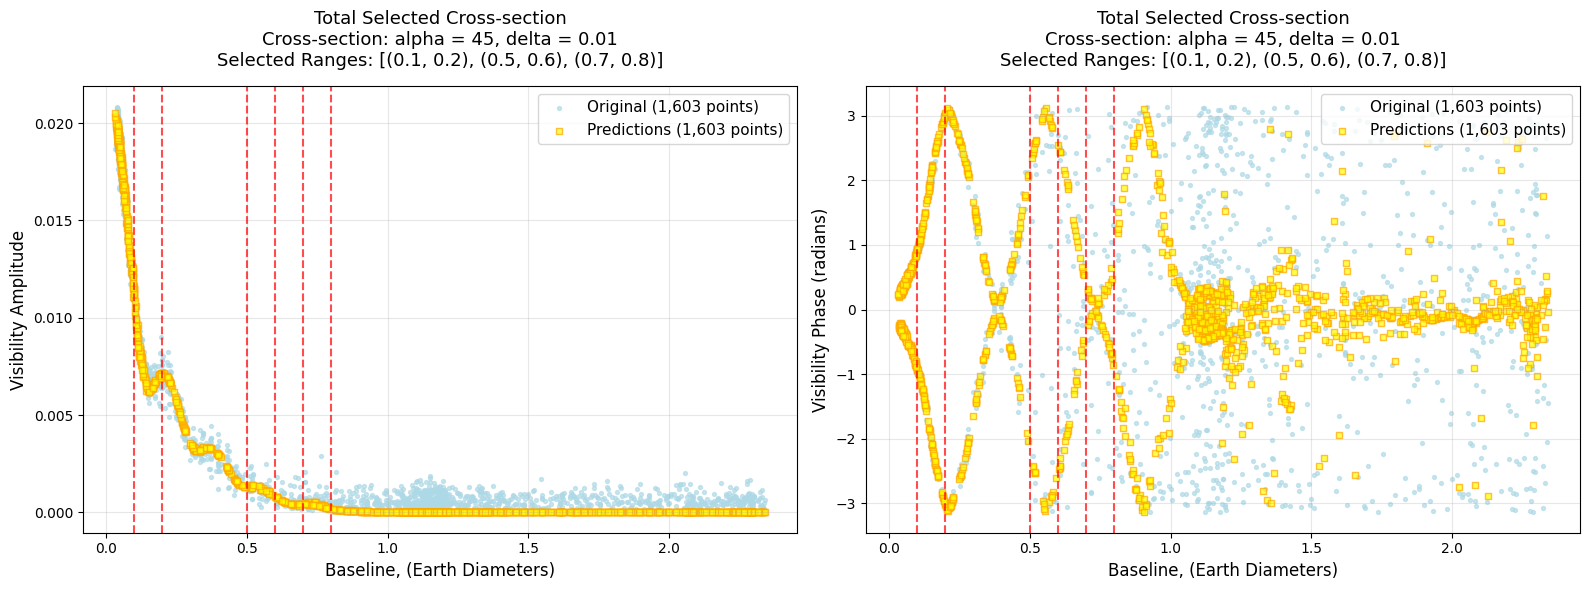

In [49]:
fig, axs = plot_whole_predictions(filtered_data_noisy, results_amplitude_whole_noisy, results_phase_whole_noisy, 
                                  used_ranges, alpha_test=alpha_test, delta_test=delta_test)

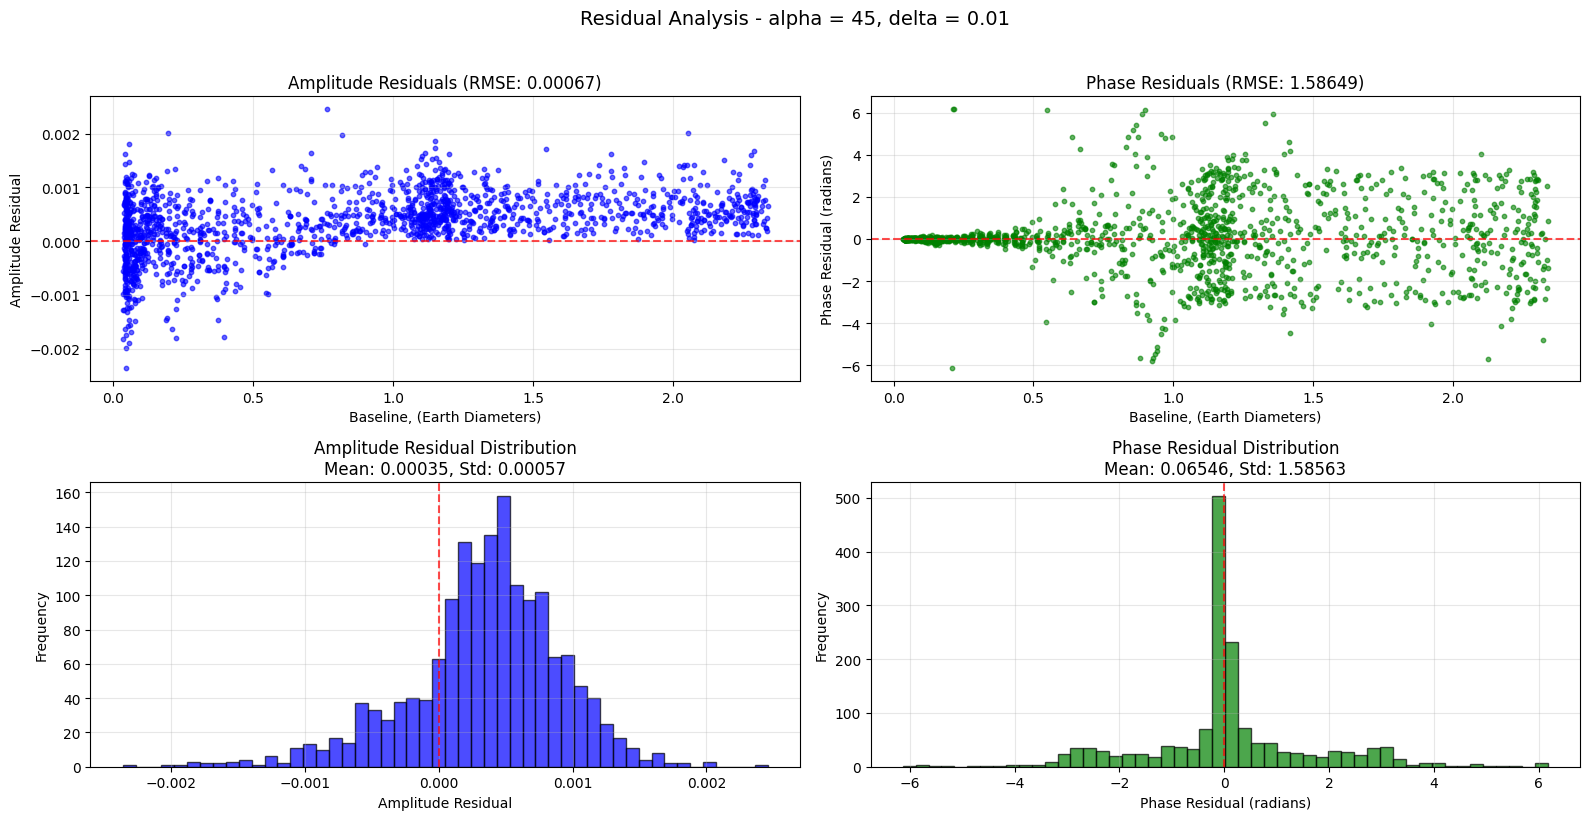

Residuals statistics:

Amplitude:
- RMSE: 0.00067
- MAE: 0.00055
- Mean residual: 0.00035
- Std residual: 0.00057

Phase:
- RMSE: 1.58649
- MAE: 0.99061
- Mean residual: 0.06546
- Std residual: 1.58563


In [50]:
fig, stats = plot_residuals_analysis(
    filtered_data=filtered_data_noisy,
    results_amplitude=results_amplitude_whole_noisy,
    results_phase=results_phase_whole_noisy,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    phase_col='Phase',
    alpha_test=alpha_test,
    delta_test=delta_test,
    figsize=(16, 8),
    return_stats=True
)

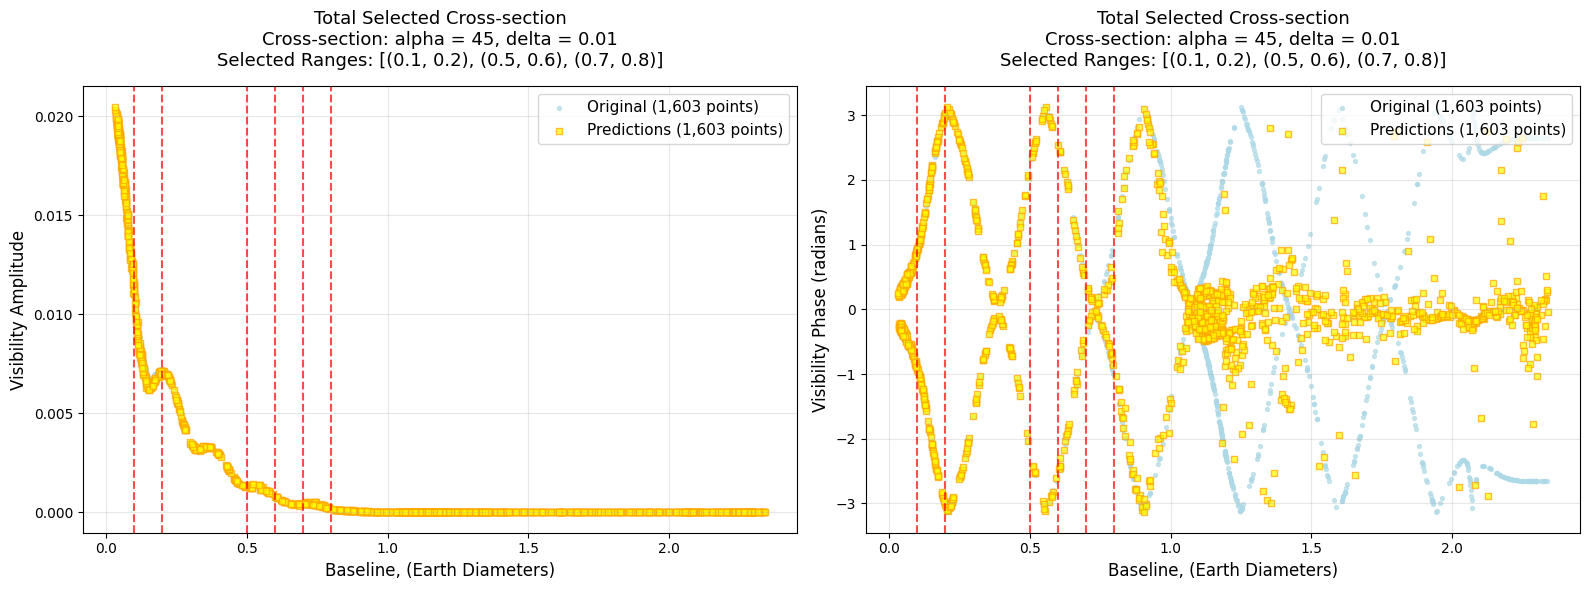

In [51]:
fig, axs = plot_whole_predictions(filtered_data, results_amplitude_whole_noisy, results_phase_whole_noisy, 
                                  used_ranges, alpha_test=alpha_test, delta_test=delta_test)

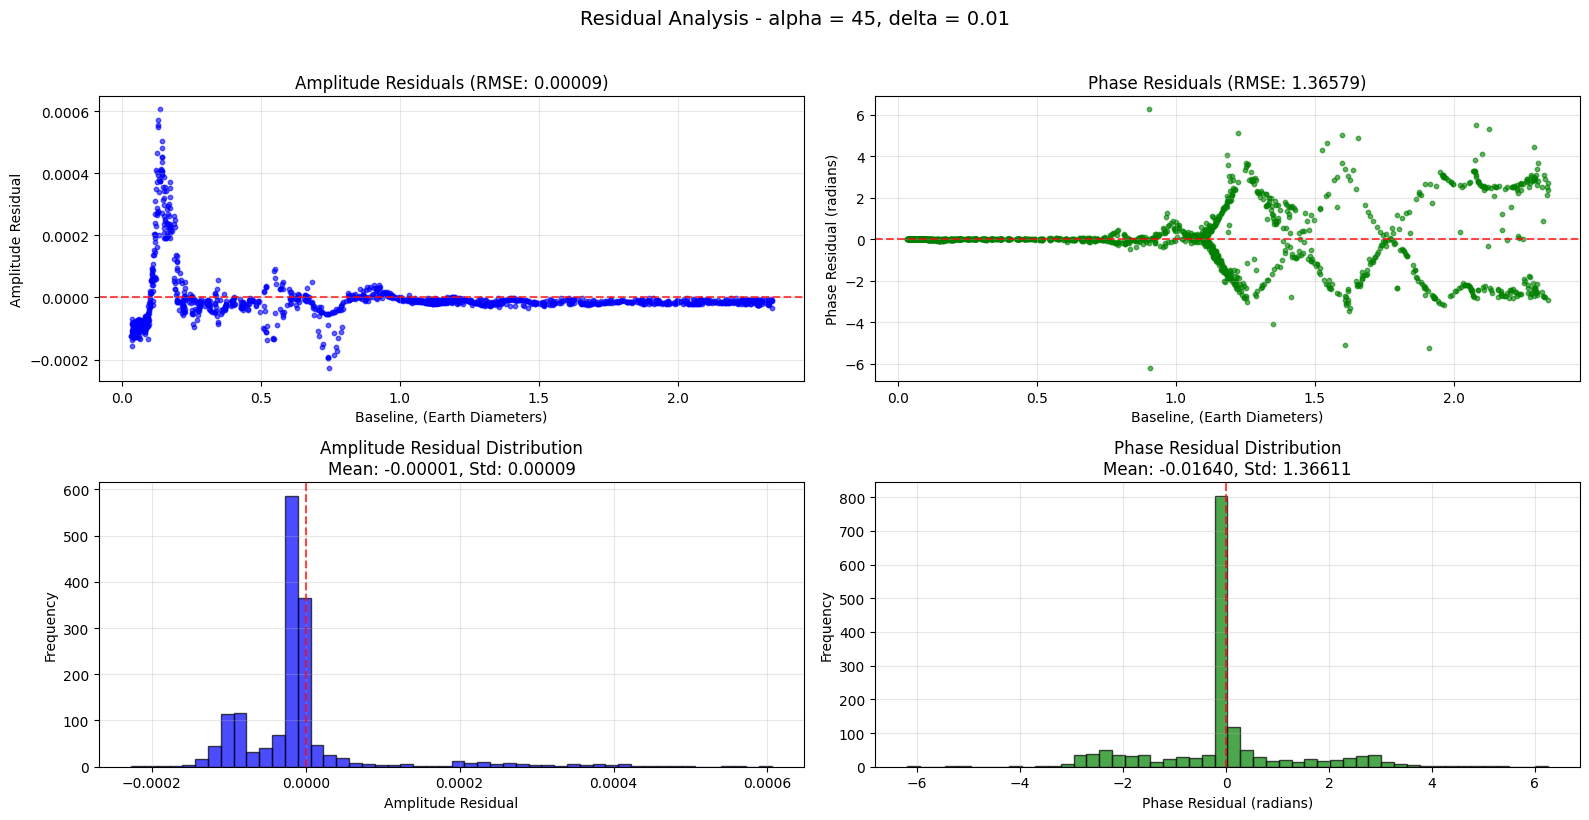

Residuals statistics:

Amplitude:
- RMSE: 0.00009
- MAE: 0.00005
- Mean residual: -0.00001
- Std residual: 0.00009

Phase:
- RMSE: 1.36579
- MAE: 0.79619
- Mean residual: -0.01640
- Std residual: 1.36611


In [52]:
fig, stats = plot_residuals_analysis(
    filtered_data=filtered_data,
    results_amplitude=results_amplitude_whole_noisy,
    results_phase=results_phase_whole_noisy,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    phase_col='Phase',
    alpha_test=alpha_test,
    delta_test=delta_test,
    figsize=(16, 8),
    return_stats=True
)

## Results and Discussions

# Crest Model Dataset (Noise Injection 20%)

## Noise Injection

In [53]:
filtered_data_noisy = add_noise(filtered_data, 
                                re_noise_percent=20, 
                                im_noise_percent=20, 
                                random_seed=RANDOM_STATE)

# calculate visibility amplitude and phase and add it to initial dataset
calculate_baseline_amplitude(dataset=filtered_data_noisy, inplace=True, sort_baselines=True)

## EDA

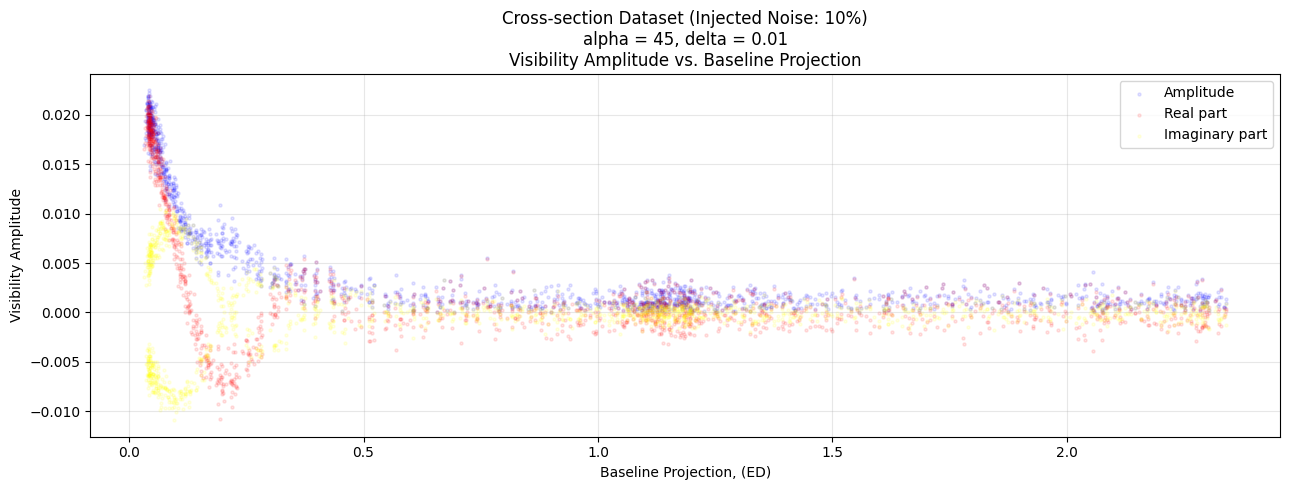

In [54]:
plot_visibility_components(
    filtered_data=filtered_data_noisy,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    real_col='Re',
    imag_col='Im',
    alpha=0.1,
    size=5,
    amplitude_color='blue',
    real_color='red',
    imag_color='yellow',
    figsize=(13, 5),
    xlabel='Baseline Projection, (ED)',
    ylabel='Visibility Amplitude',
    title_prefix='Cross-section Dataset (Injected Noise: 10%)',
    alpha_test=alpha_test,
    delta_test=delta_test,
    grid=True
);

## Data Preparation

In [55]:
selected_data_noisy, rest_data_noisy, used_ranges = select_by_baseline_ranges(dataset=filtered_data_noisy,
                                                                  baseline_col='Baseline',
                                                                  ranges=[(0.1, 0.2), (0.5, 0.6), (0.7, 0.8)],
                                                                  mode='specified'
                                                                  )

Mode: specified
Selected baseline ranges: [(0.1, 0.2), (0.5, 0.6), (0.7, 0.8)]
Points selected: 223 from 1,603 (13.9%)
Selected range sizes: [0.1, 0.09999999999999998, 0.10000000000000009]


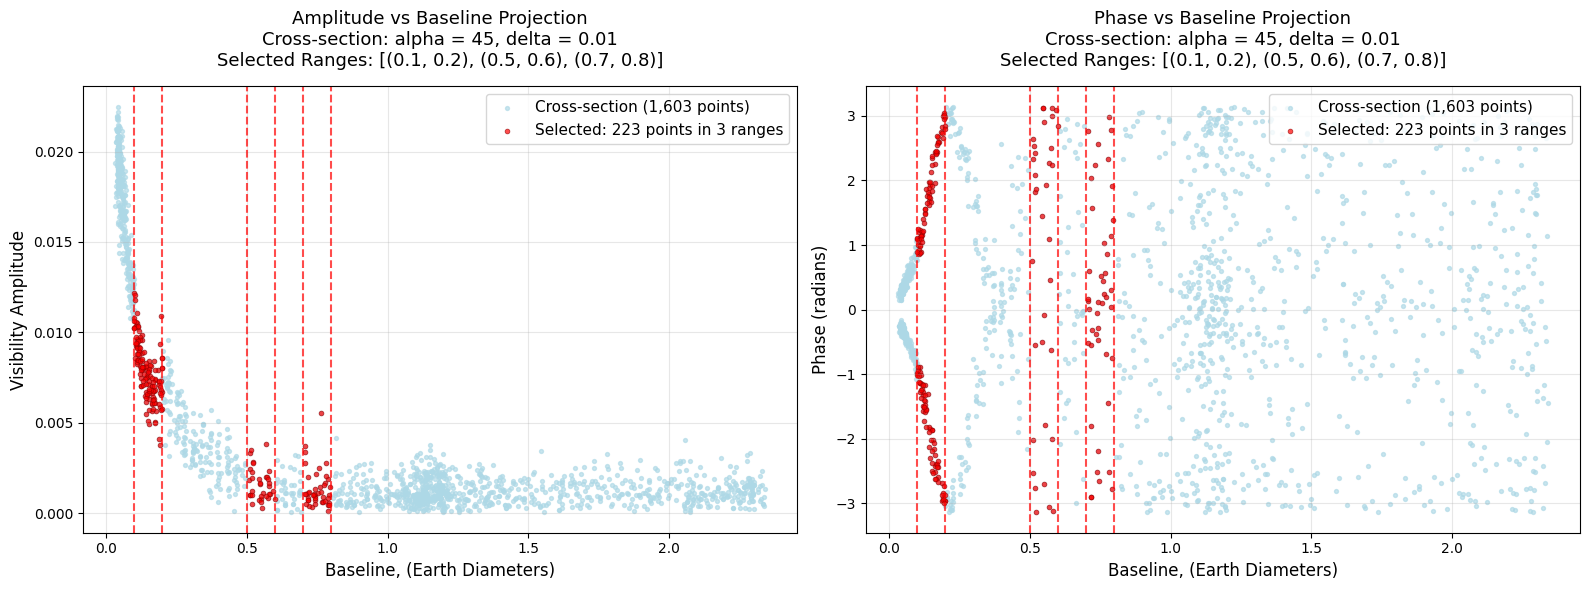

In [56]:
plot_amplitude_phase_with_selection(filtered_data_noisy, selected_data_noisy, used_ranges,
                                    alpha_test=alpha_test, delta_test=delta_test);

In [57]:
rest_data_noisy = rest_data_noisy.sort_values('Baseline').reset_index(drop=True)

X_data = rest_data_noisy[['U', 'V', 'Baseline']].values
y_data = rest_data_noisy[['Re', 'Im']].values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_data)

X_tensor = torch.from_numpy(X_scaled).float()
y_tensor = torch.from_numpy(y_scaled).float()

In [58]:
# creating initial dataset
dataset_noisy = create_dataset_from_data(X_tensor, y_tensor, train_ratio=1-TEST_SIZE, device=device)

In [59]:
# initialize model
model_noisy = KAN(width=[3, 12, 12, 2],
            grid=5,
            k=3,
            seed=RANDOM_STATE,
            device=device)

checkpoint directory created: ./model
saving model version 0.0


## Training

In [60]:
history_noisy = model_noisy.fit(dataset_noisy,
                            opt="LBFGS",
                            steps=1000,
                            update_grid=True);

| train_loss: 1.89e-01 | test_loss: 2.14e-01 | reg: 5.61e+01 | : 100%|█| 1000/1000 [10:30<00:00,  1.

saving model version 0.1


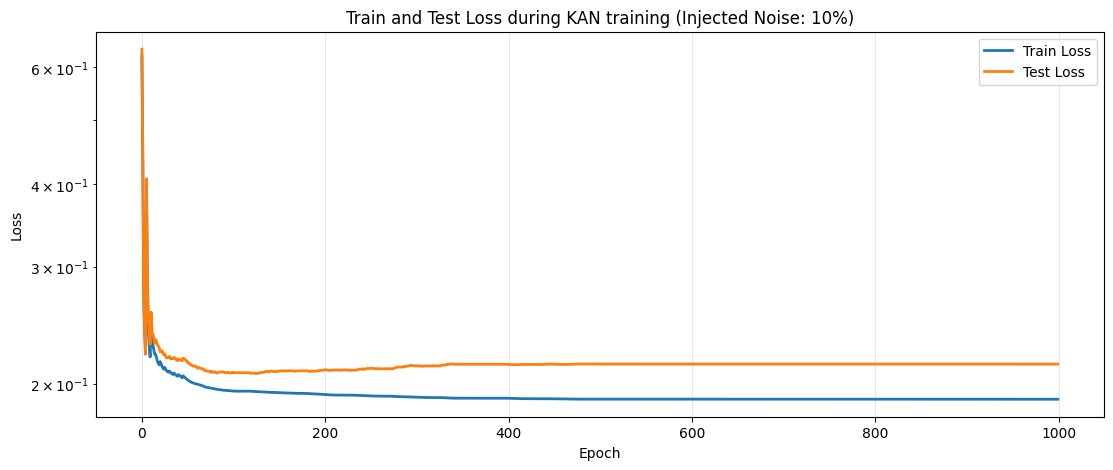

In [61]:
plt.figure(figsize=(13, 5))
plt.plot(history_noisy['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history_noisy['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss during KAN training (Injected Noise: 10%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

## Testing

### Selected Ranges

In [62]:
test_data_raw = selected_data_noisy[['U', 'V', 'Baseline']].values
test_data_scaled = scaler_X.transform(test_data_raw)
test_data = torch.from_numpy(test_data_scaled).float()

In [63]:
results_scaled = model(test_data)

In [64]:
results_denormalized = scaler_y.inverse_transform(results_scaled.detach().numpy())
results_amplitude_noisy = np.sqrt(results_denormalized[:, 0]**2 + results_denormalized[:, 1]**2)
results_phase_noisy = np.atan2(results_denormalized[:, 1], results_denormalized[:, 0])

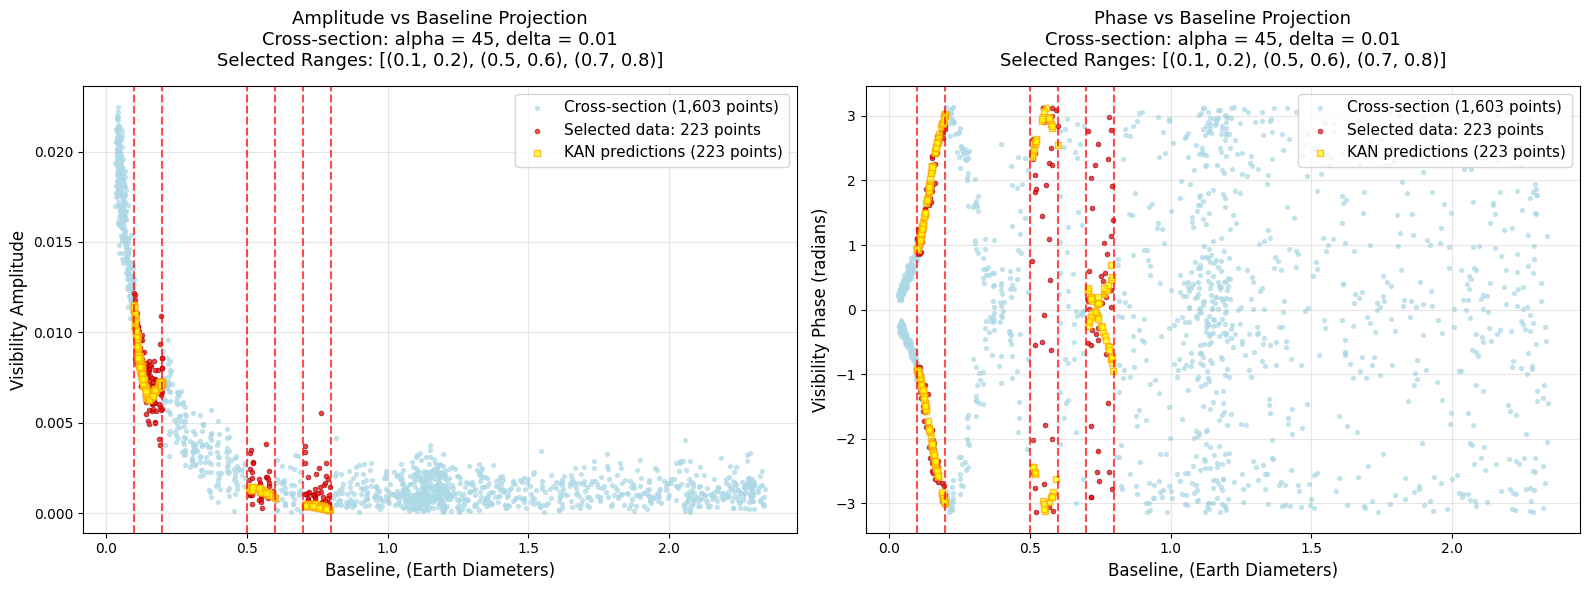

In [65]:
fig, axs = plot_predictions_comparison(filtered_data_noisy, selected_data_noisy, results_amplitude_noisy, 
                                       results_phase_noisy, used_ranges,
                                       alpha_test=alpha_test, delta_test=delta_test)

### Whole Dataset

In [66]:
whole_data_raw = filtered_data_noisy[['U', 'V', 'Baseline']].values
whole_data_scaled = scaler_X.transform(whole_data_raw)
whole_data = torch.from_numpy(whole_data_scaled).float()

In [67]:
results_whole_scaled = model(whole_data)

In [68]:
results_whole_denormalized = scaler_y.inverse_transform(results_whole_scaled.detach().numpy())
results_amplitude_whole_noisy = np.sqrt(results_whole_denormalized[:, 0]**2 + results_whole_denormalized[:, 1]**2)
results_phase_whole_noisy = np.atan2(results_whole_denormalized[:, 1], results_whole_denormalized[:, 0])

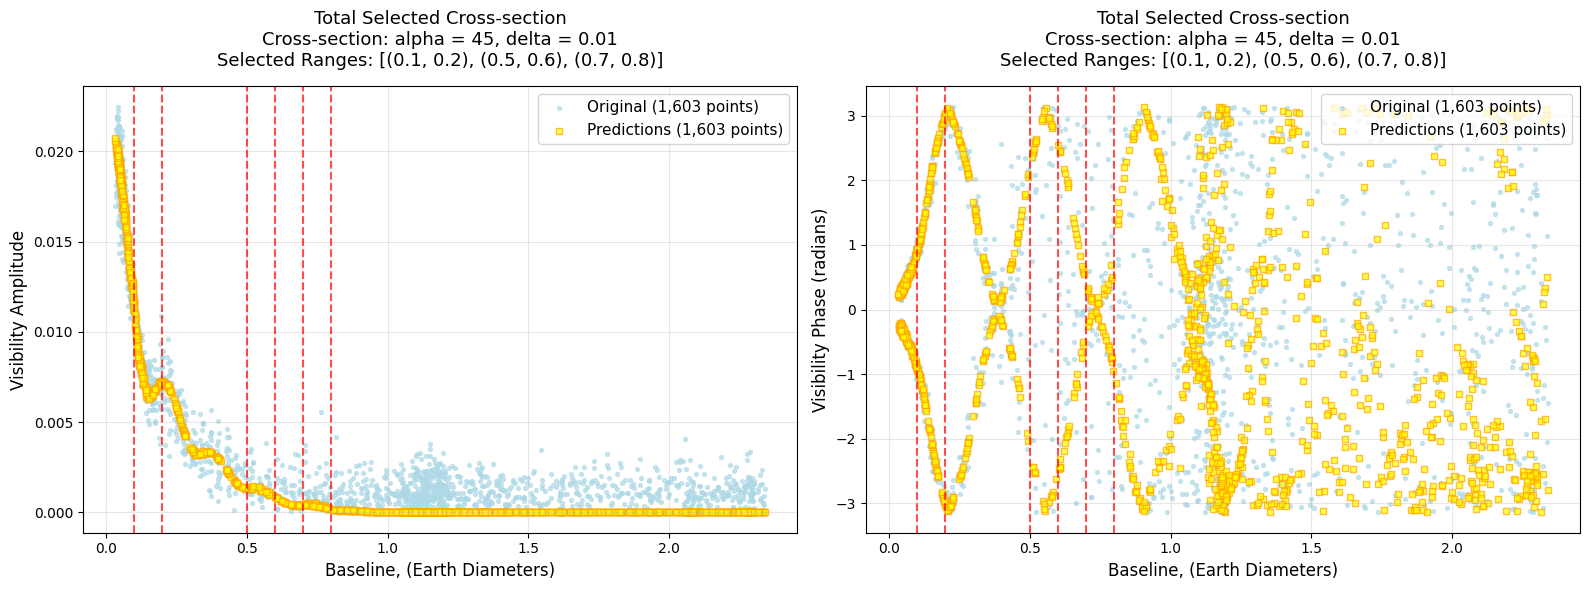

In [69]:
fig, axs = plot_whole_predictions(filtered_data_noisy, results_amplitude_whole_noisy, results_phase_whole_noisy, 
                                  used_ranges, alpha_test=alpha_test, delta_test=delta_test)

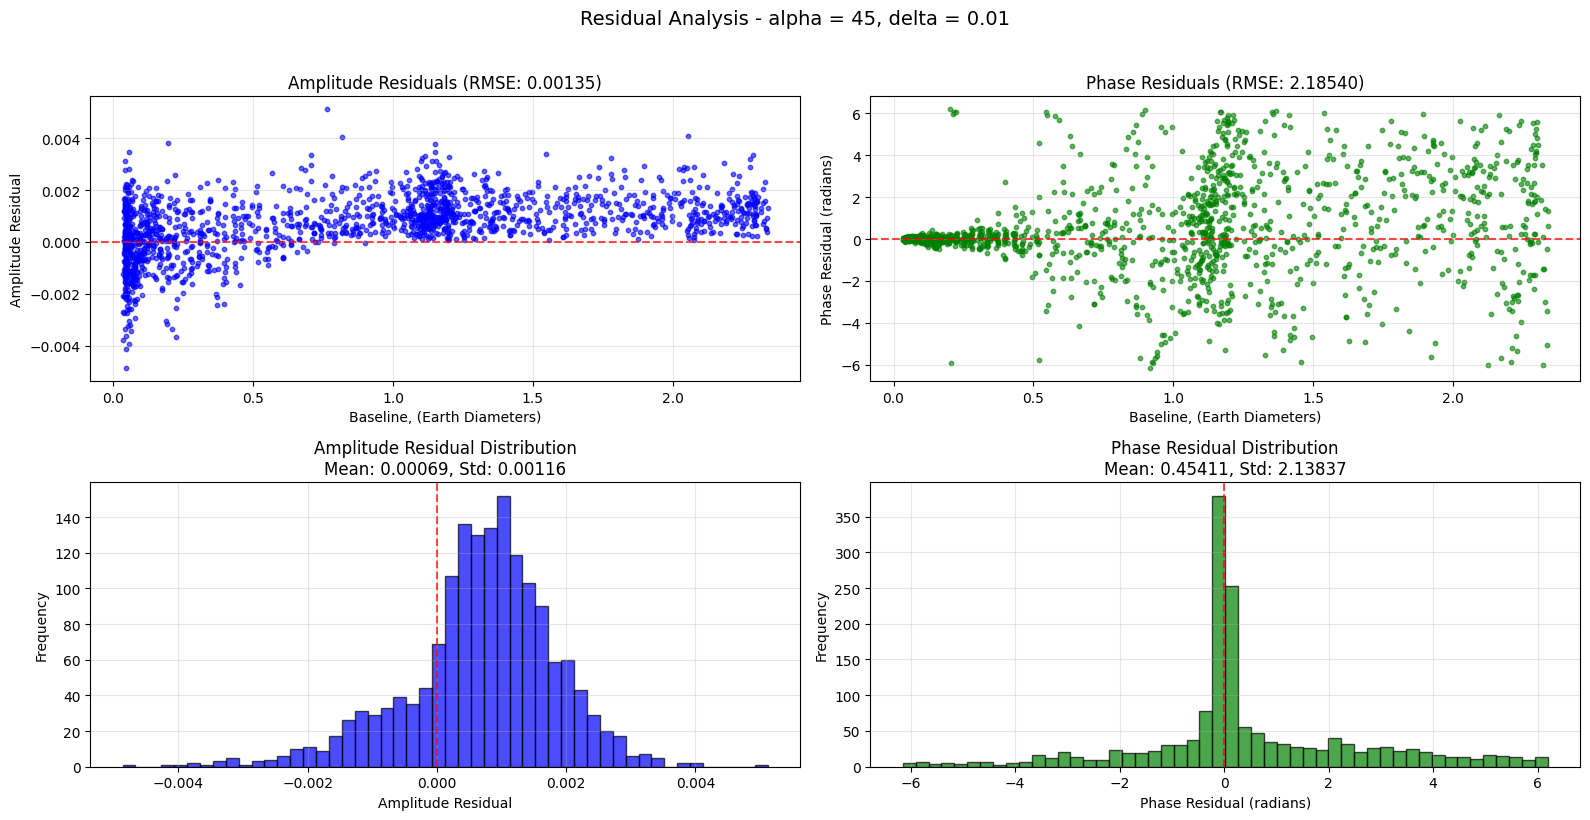

Residuals statistics:

Amplitude:
- RMSE: 0.00135
- MAE: 0.00111
- Mean residual: 0.00069
- Std residual: 0.00116

Phase:
- RMSE: 2.18540
- MAE: 1.41366
- Mean residual: 0.45411
- Std residual: 2.13837


In [70]:
fig, stats = plot_residuals_analysis(
    filtered_data=filtered_data_noisy,
    results_amplitude=results_amplitude_whole_noisy,
    results_phase=results_phase_whole_noisy,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    phase_col='Phase',
    alpha_test=alpha_test,
    delta_test=delta_test,
    figsize=(16, 8),
    return_stats=True
)

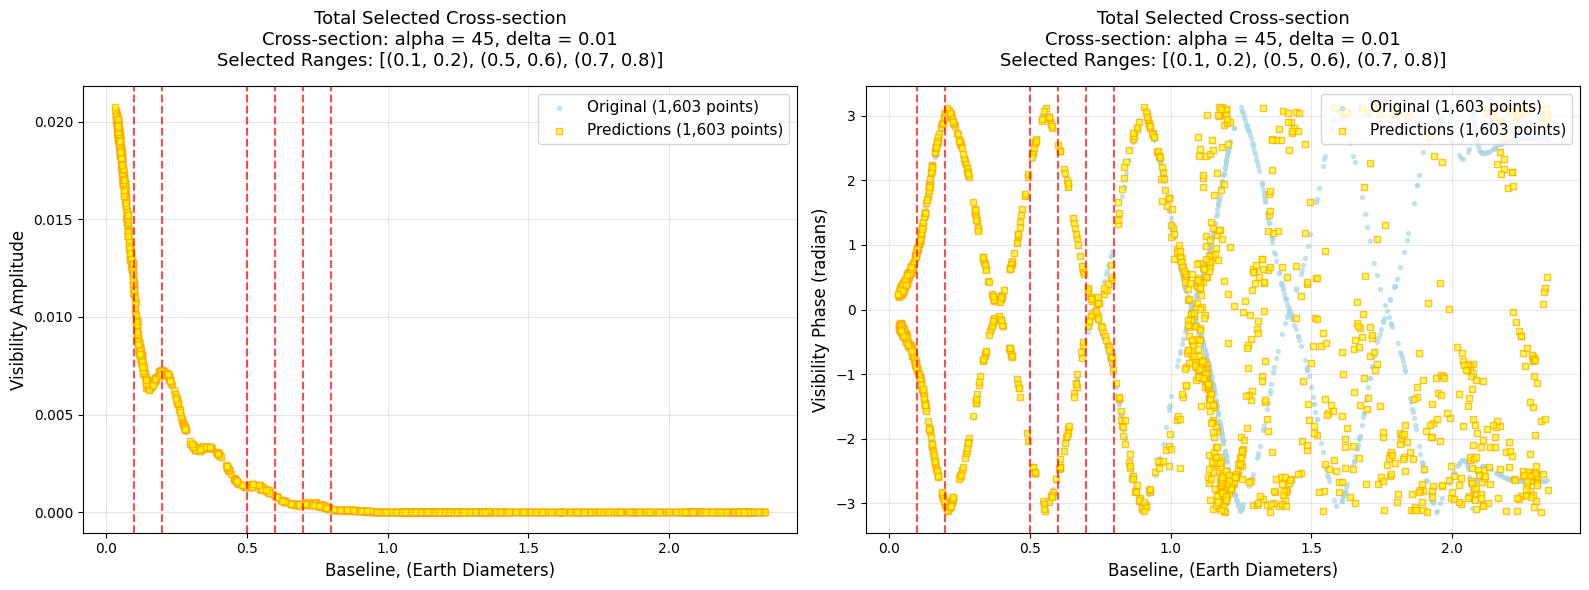

In [71]:
fig, axs = plot_whole_predictions(filtered_data, results_amplitude_whole_noisy, results_phase_whole_noisy, 
                                  used_ranges, alpha_test=alpha_test, delta_test=delta_test)

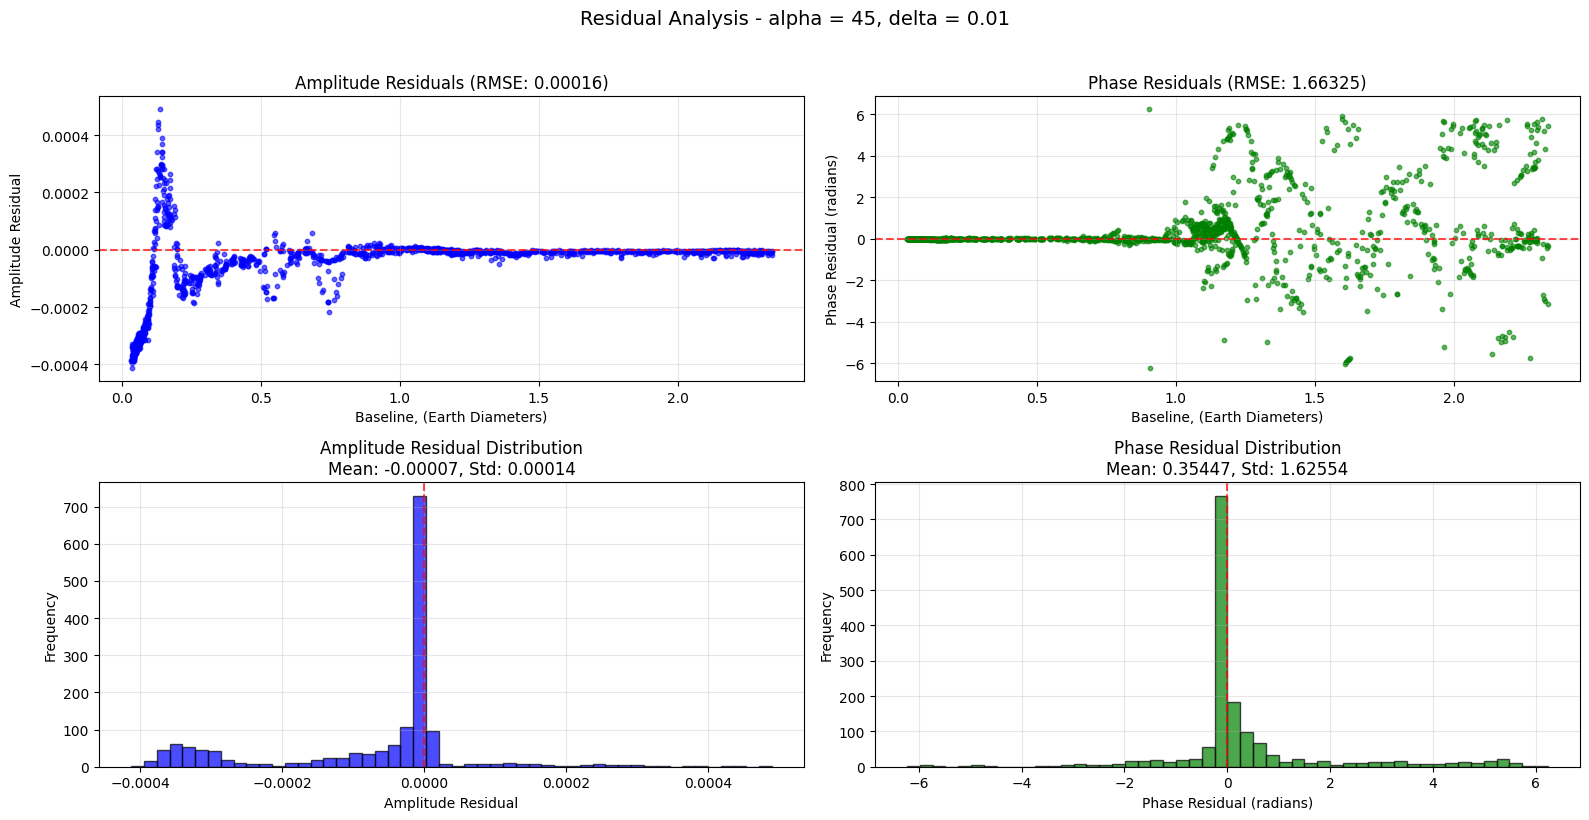

Residuals statistics:

Amplitude:
- RMSE: 0.00016
- MAE: 0.00009
- Mean residual: -0.00007
- Std residual: 0.00014

Phase:
- RMSE: 1.66325
- MAE: 0.81610
- Mean residual: 0.35447
- Std residual: 1.62554


In [72]:
fig, stats = plot_residuals_analysis(
    filtered_data=filtered_data,
    results_amplitude=results_amplitude_whole_noisy,
    results_phase=results_phase_whole_noisy,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    phase_col='Phase',
    alpha_test=alpha_test,
    delta_test=delta_test,
    figsize=(16, 8),
    return_stats=True
)

# Crest Model Dataset (Noise Injection 30%)

## Noise Injection

In [73]:
filtered_data_noisy = add_noise(filtered_data, 
                                re_noise_percent=30, 
                                im_noise_percent=30, 
                                random_seed=RANDOM_STATE)

# calculate visibility amplitude and phase and add it to initial dataset
calculate_baseline_amplitude(dataset=filtered_data_noisy, inplace=True, sort_baselines=True)

## EDA

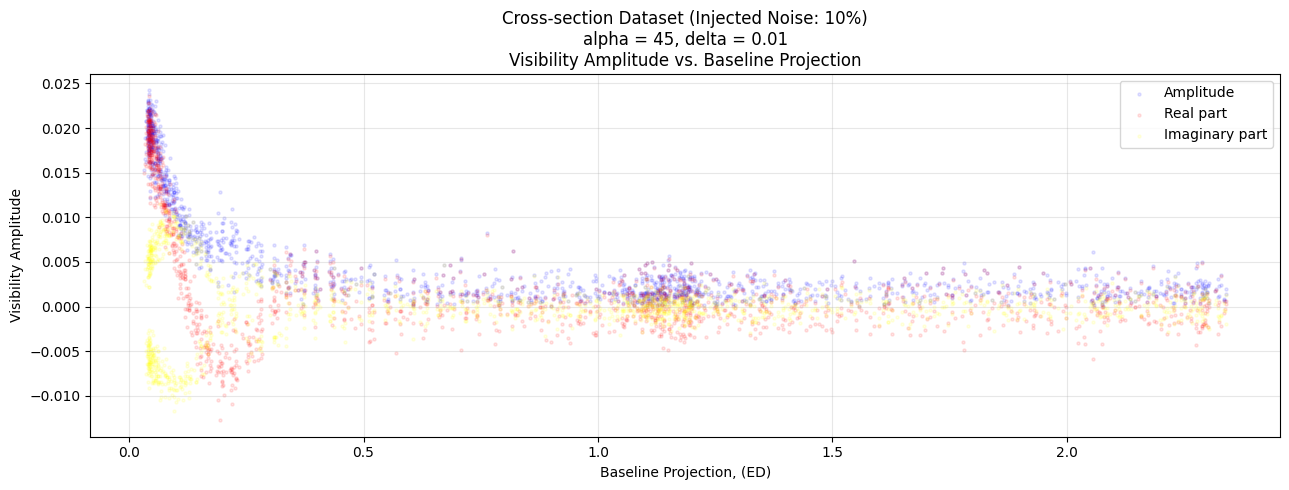

In [74]:
plot_visibility_components(
    filtered_data=filtered_data_noisy,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    real_col='Re',
    imag_col='Im',
    alpha=0.1,
    size=5,
    amplitude_color='blue',
    real_color='red',
    imag_color='yellow',
    figsize=(13, 5),
    xlabel='Baseline Projection, (ED)',
    ylabel='Visibility Amplitude',
    title_prefix='Cross-section Dataset (Injected Noise: 10%)',
    alpha_test=alpha_test,
    delta_test=delta_test,
    grid=True
);

## Data Preparation

In [75]:
selected_data_noisy, rest_data_noisy, used_ranges = select_by_baseline_ranges(dataset=filtered_data_noisy,
                                                                  baseline_col='Baseline',
                                                                  ranges=[(0.1, 0.2), (0.5, 0.6), (0.7, 0.8)],
                                                                  mode='specified'
                                                                  )

Mode: specified
Selected baseline ranges: [(0.1, 0.2), (0.5, 0.6), (0.7, 0.8)]
Points selected: 223 from 1,603 (13.9%)
Selected range sizes: [0.1, 0.09999999999999998, 0.10000000000000009]


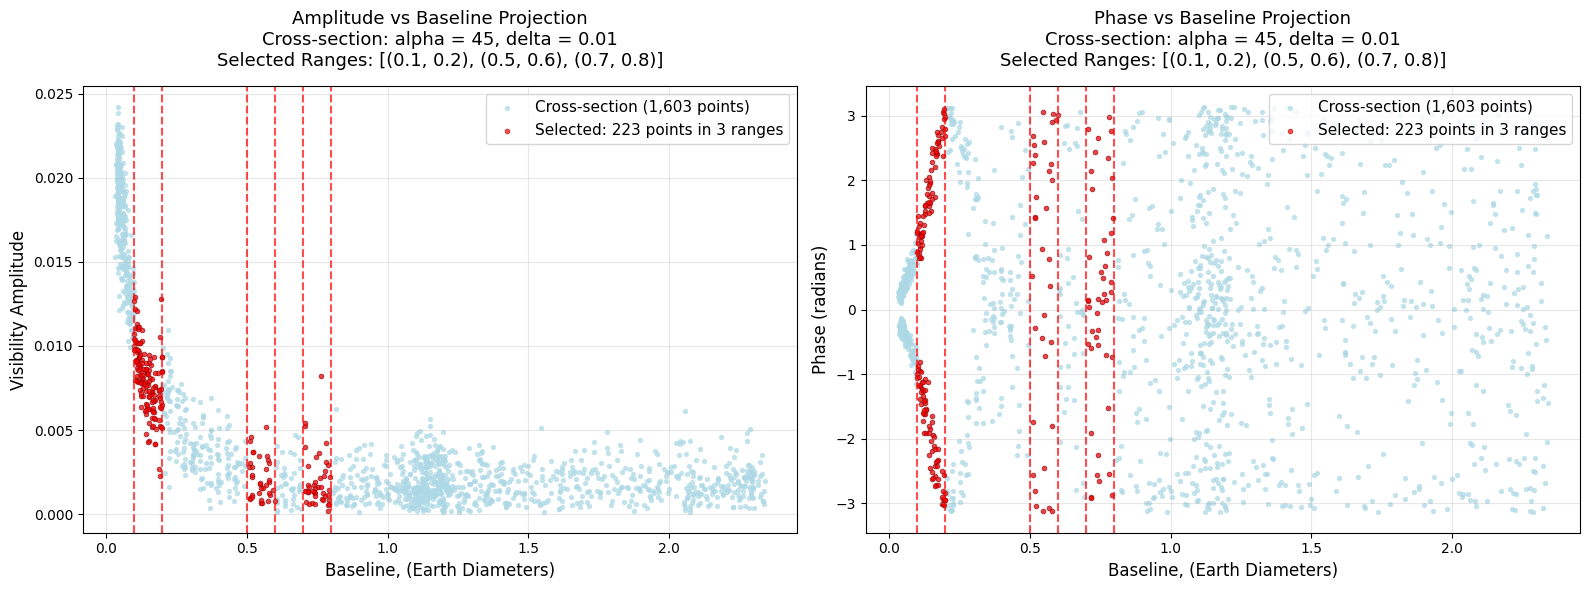

In [76]:
plot_amplitude_phase_with_selection(filtered_data_noisy, selected_data_noisy, used_ranges,
                                    alpha_test=alpha_test, delta_test=delta_test);

In [77]:
rest_data_noisy = rest_data_noisy.sort_values('Baseline').reset_index(drop=True)

X_data = rest_data_noisy[['U', 'V', 'Baseline']].values
y_data = rest_data_noisy[['Re', 'Im']].values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_data)

X_tensor = torch.from_numpy(X_scaled).float()
y_tensor = torch.from_numpy(y_scaled).float()

In [78]:
# creating initial dataset
dataset_noisy = create_dataset_from_data(X_tensor, y_tensor, train_ratio=1-TEST_SIZE, device=device)

In [79]:
# initialize model
model_noisy = KAN(width=[3, 12, 12, 2],
            grid=5,
            k=3,
            seed=RANDOM_STATE,
            device=device)

checkpoint directory created: ./model
saving model version 0.0


## Training

In [80]:
history_noisy = model_noisy.fit(dataset_noisy,
                            opt="LBFGS",
                            steps=1000,
                            update_grid=True);

| train_loss: 2.69e-01 | test_loss: 6.35e-01 | reg: 6.82e+01 | : 100%|█| 1000/1000 [14:23<00:00,  1.

saving model version 0.1


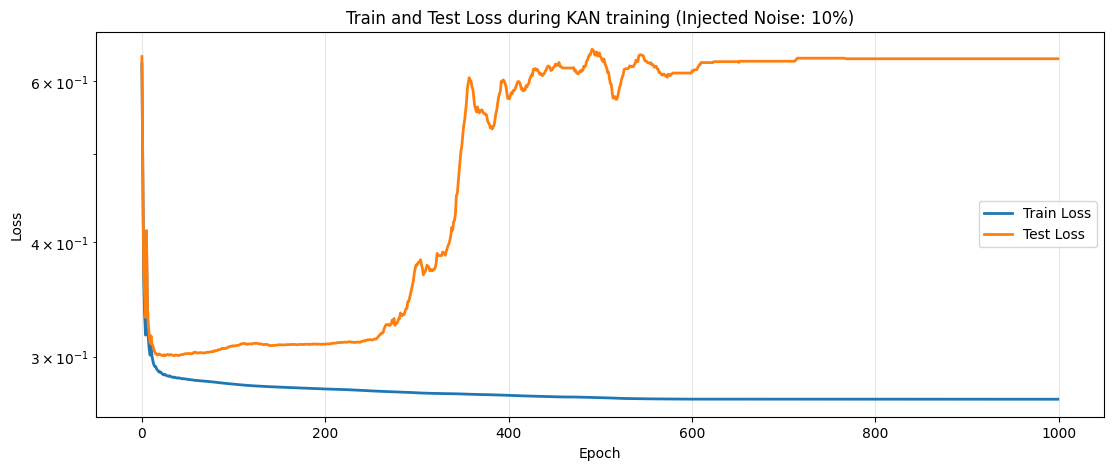

In [81]:
plt.figure(figsize=(13, 5))
plt.plot(history_noisy['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history_noisy['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss during KAN training (Injected Noise: 10%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

## Testing

### Selected Ranges

In [82]:
test_data_raw = selected_data_noisy[['U', 'V', 'Baseline']].values
test_data_scaled = scaler_X.transform(test_data_raw)
test_data = torch.from_numpy(test_data_scaled).float()

In [83]:
results_scaled = model(test_data)

In [84]:
results_denormalized = scaler_y.inverse_transform(results_scaled.detach().numpy())
results_amplitude_noisy = np.sqrt(results_denormalized[:, 0]**2 + results_denormalized[:, 1]**2)
results_phase_noisy = np.atan2(results_denormalized[:, 1], results_denormalized[:, 0])

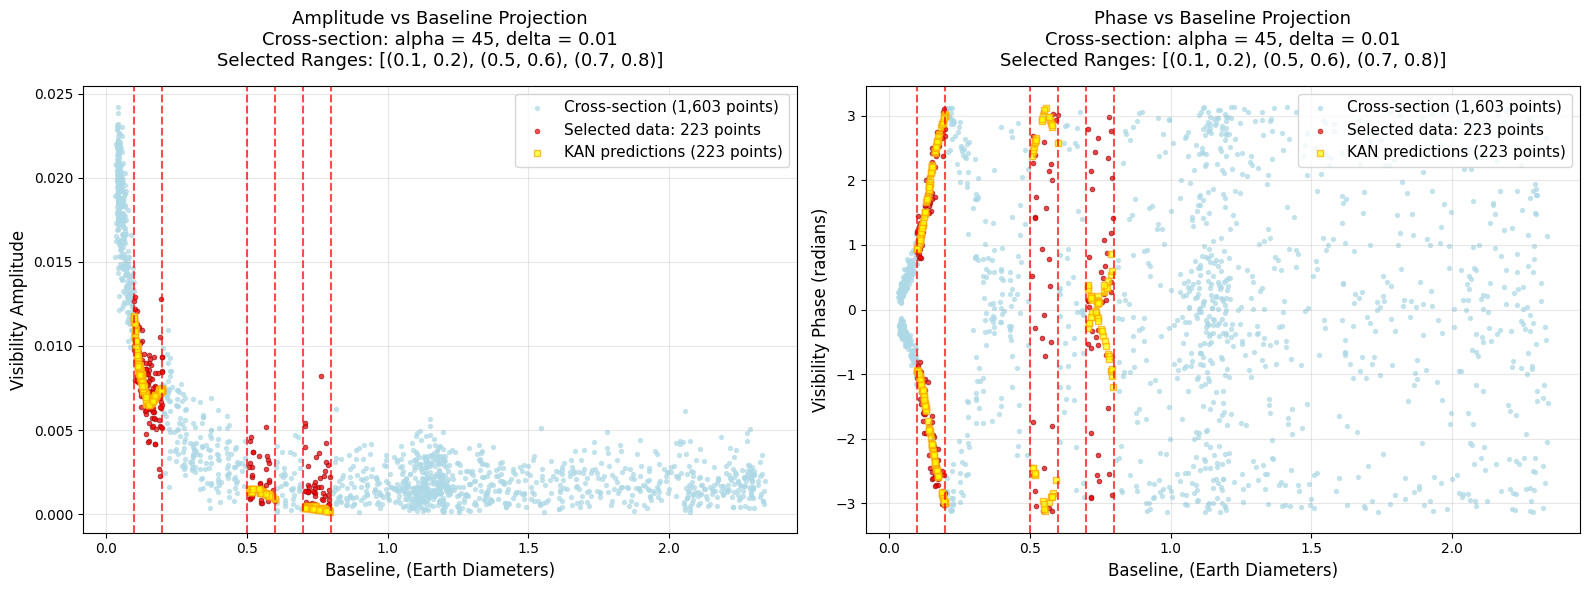

In [85]:
fig, axs = plot_predictions_comparison(filtered_data_noisy, selected_data_noisy, results_amplitude_noisy, 
                                       results_phase_noisy, used_ranges,
                                       alpha_test=alpha_test, delta_test=delta_test)

### Whole Dataset

In [86]:
whole_data_raw = filtered_data_noisy[['U', 'V', 'Baseline']].values
whole_data_scaled = scaler_X.transform(whole_data_raw)
whole_data = torch.from_numpy(whole_data_scaled).float()

In [87]:
results_whole_scaled = model(whole_data)

In [88]:
results_whole_denormalized = scaler_y.inverse_transform(results_whole_scaled.detach().numpy())
results_amplitude_whole_noisy = np.sqrt(results_whole_denormalized[:, 0]**2 + results_whole_denormalized[:, 1]**2)
results_phase_whole_noisy = np.atan2(results_whole_denormalized[:, 1], results_whole_denormalized[:, 0])

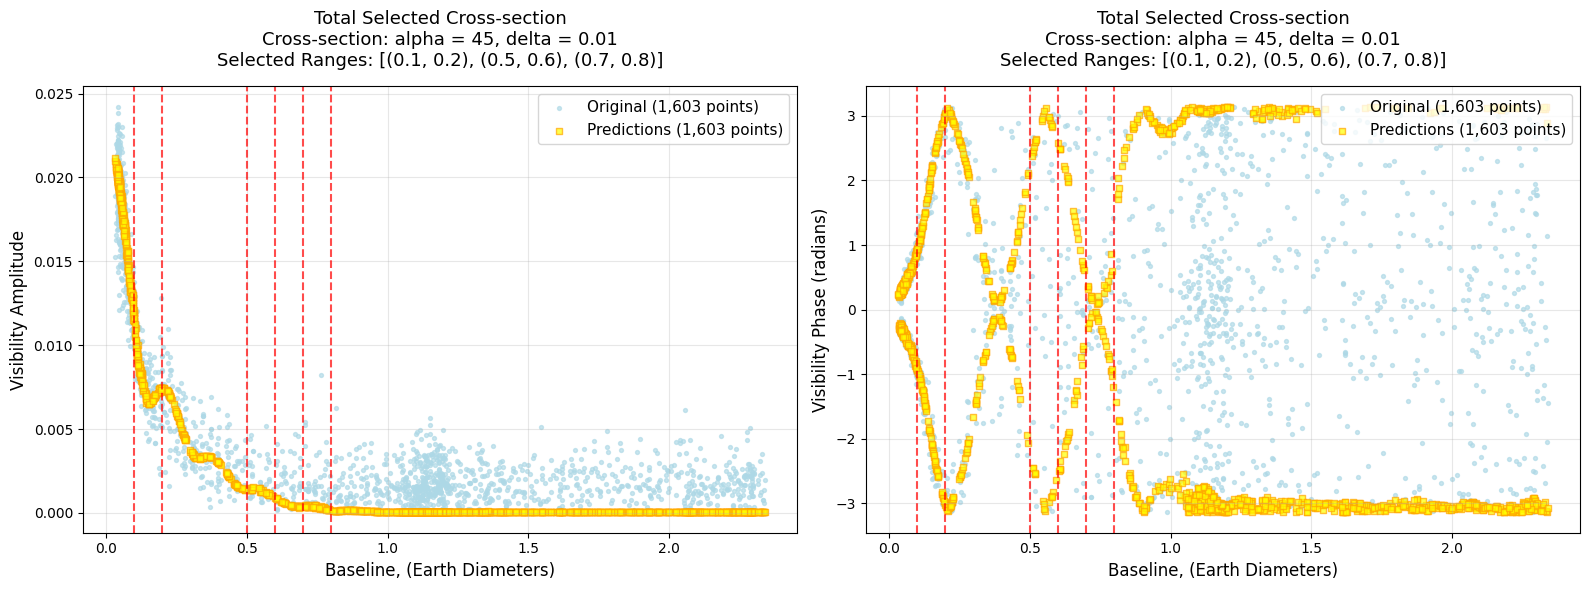

In [89]:
fig, axs = plot_whole_predictions(filtered_data_noisy, results_amplitude_whole_noisy, results_phase_whole_noisy, 
                                  used_ranges, alpha_test=alpha_test, delta_test=delta_test)

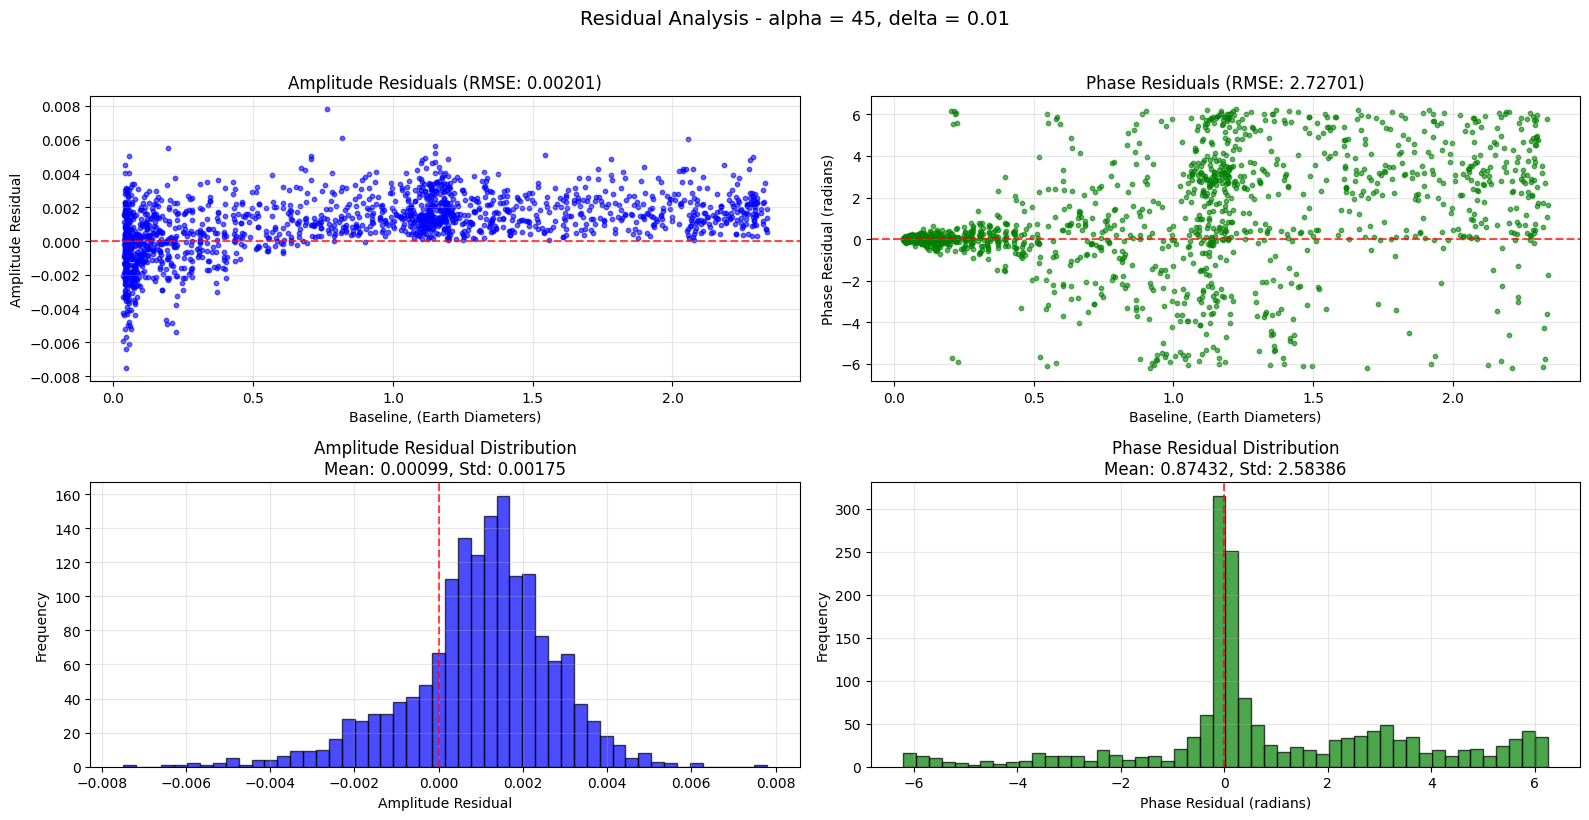

Residuals statistics:

Amplitude:
- RMSE: 0.00201
- MAE: 0.00165
- Mean residual: 0.00099
- Std residual: 0.00175

Phase:
- RMSE: 2.72701
- MAE: 1.85193
- Mean residual: 0.87432
- Std residual: 2.58386


In [90]:
fig, stats = plot_residuals_analysis(
    filtered_data=filtered_data_noisy,
    results_amplitude=results_amplitude_whole_noisy,
    results_phase=results_phase_whole_noisy,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    phase_col='Phase',
    alpha_test=alpha_test,
    delta_test=delta_test,
    figsize=(16, 8),
    return_stats=True
)

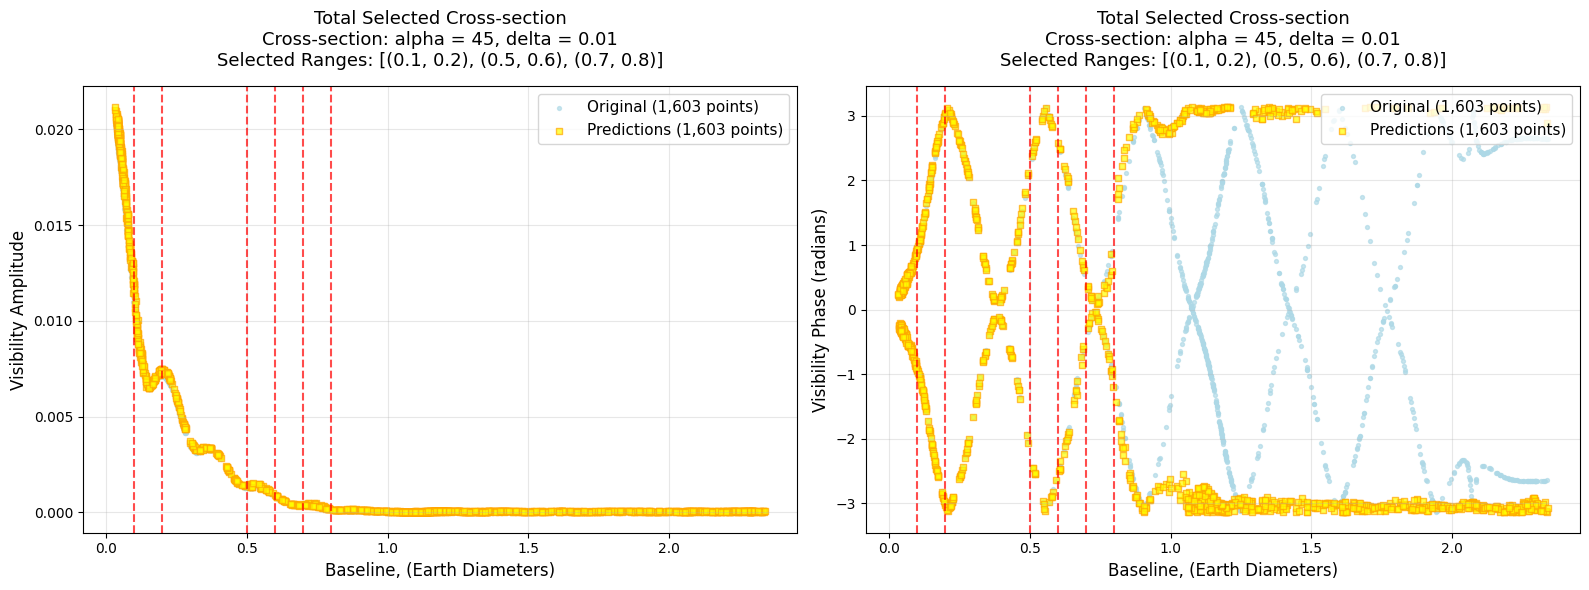

In [91]:
fig, axs = plot_whole_predictions(filtered_data, results_amplitude_whole_noisy, results_phase_whole_noisy, 
                                  used_ranges, alpha_test=alpha_test, delta_test=delta_test)

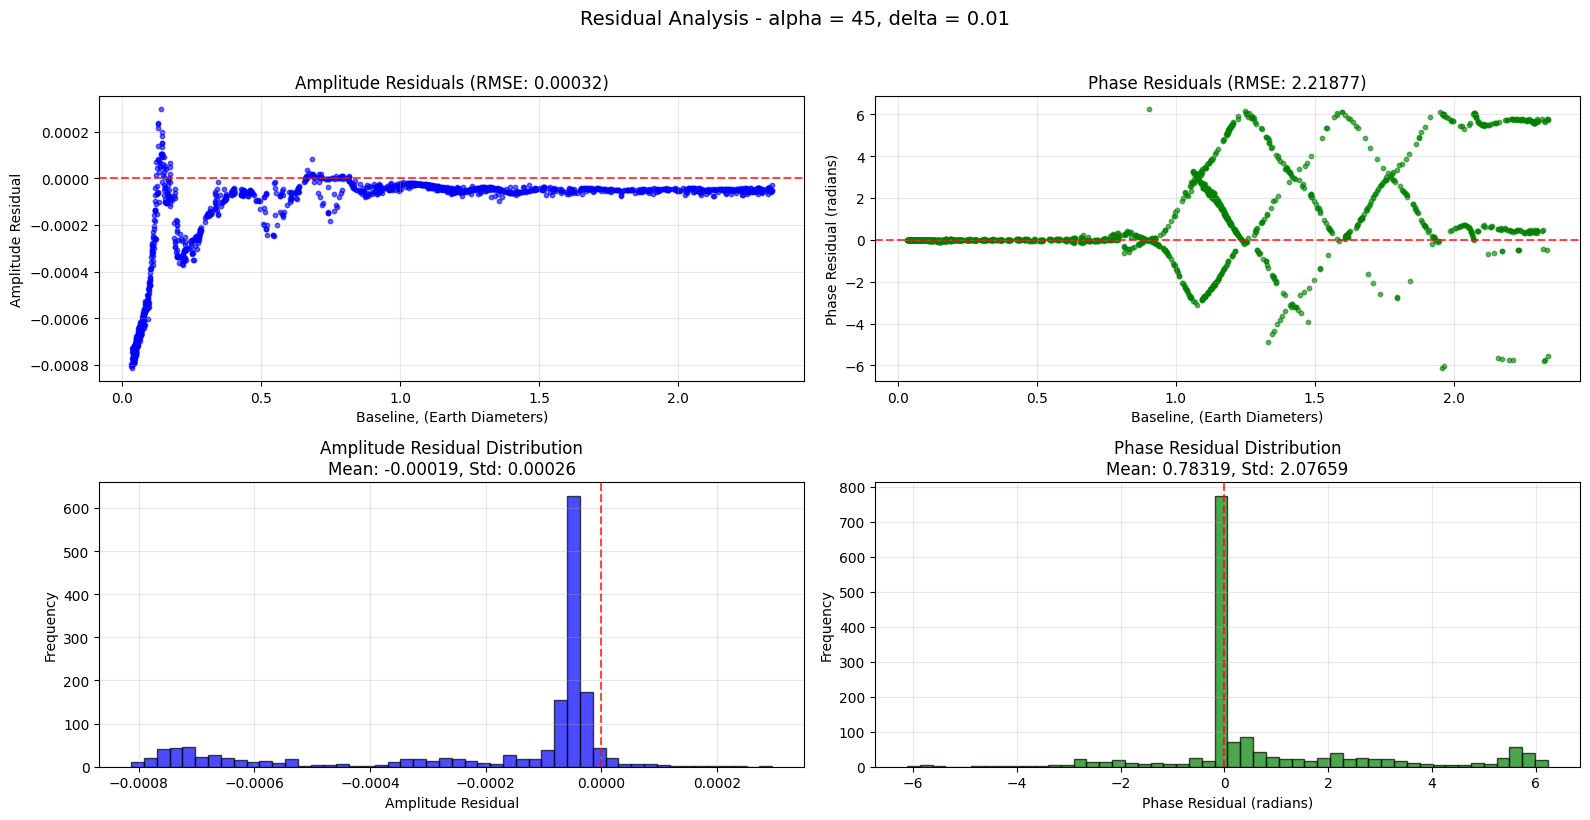

Residuals statistics:

Amplitude:
- RMSE: 0.00032
- MAE: 0.00020
- Mean residual: -0.00019
- Std residual: 0.00026

Phase:
- RMSE: 2.21877
- MAE: 1.25704
- Mean residual: 0.78319
- Std residual: 2.07659


In [92]:
fig, stats = plot_residuals_analysis(
    filtered_data=filtered_data,
    results_amplitude=results_amplitude_whole_noisy,
    results_phase=results_phase_whole_noisy,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    phase_col='Phase',
    alpha_test=alpha_test,
    delta_test=delta_test,
    figsize=(16, 8),
    return_stats=True
)

# VLBA M87 Dataset 19.06.2024

## Data Loading

In [94]:
# load data from text file indicated in DATASET_FILE global variable
dataset_m87 = pd.read_csv('data\\M87_VLBA_19062024.txt', sep='\t')

In [95]:
# general information about dataset
dataset_m87.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29298 entries, 0 to 29297
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   U       29298 non-null  float64
 1   V       29298 non-null  float64
 2   Re      29298 non-null  float64
 3   Im      29298 non-null  float64
dtypes: float64(4)
memory usage: 915.7 KB


## EDA

In [96]:
# calculate visibility amplitude and phase and add it to initial dataset
calculate_baseline_amplitude(dataset=dataset_m87, inplace=True, sort_baselines=True)

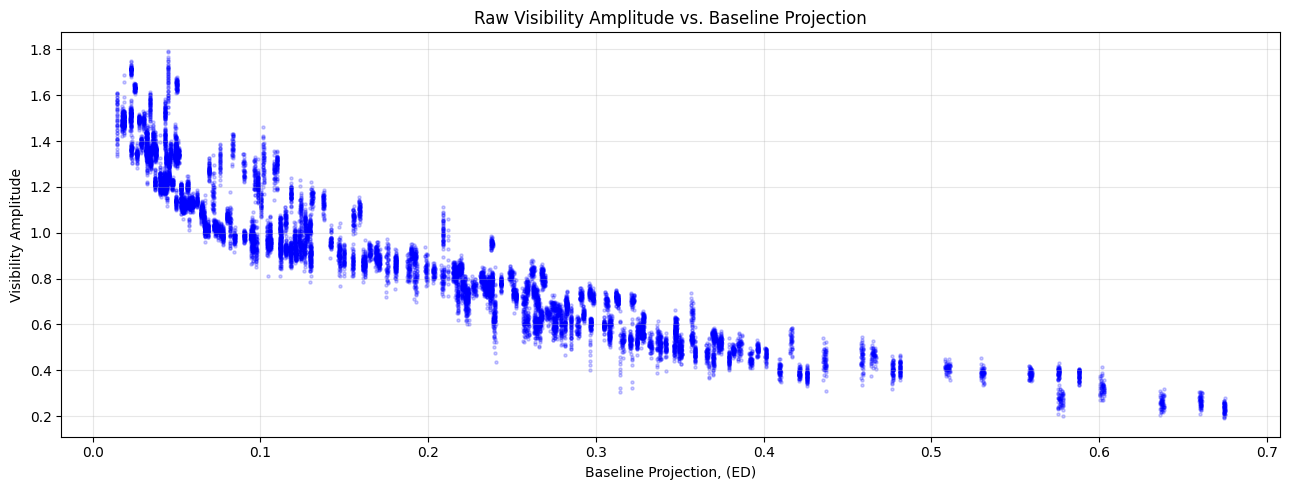

In [97]:
plot_scatter(x=dataset_m87['Baseline'],
             y=dataset_m87['Amplitude'],
             xlabel='Baseline Projection, (ED)',
             ylabel='Visibility Amplitude',
             title='Raw Visibility Amplitude vs. Baseline Projection',
             grid=True,
             figsize=(13, 5)
             )

In [217]:
# extract visibility amplitude along the cross-section
delta_test = 0.01
alpha_test = 25

filtered_data, mask, distance = cross_section(dataset_m87, 
                                              delta=delta_test, 
                                              alpha_deg=alpha_test)

Angle: 25, (deg.)
Cross-section width: 0.01
Number of points: 4234/29298 (14.5%)


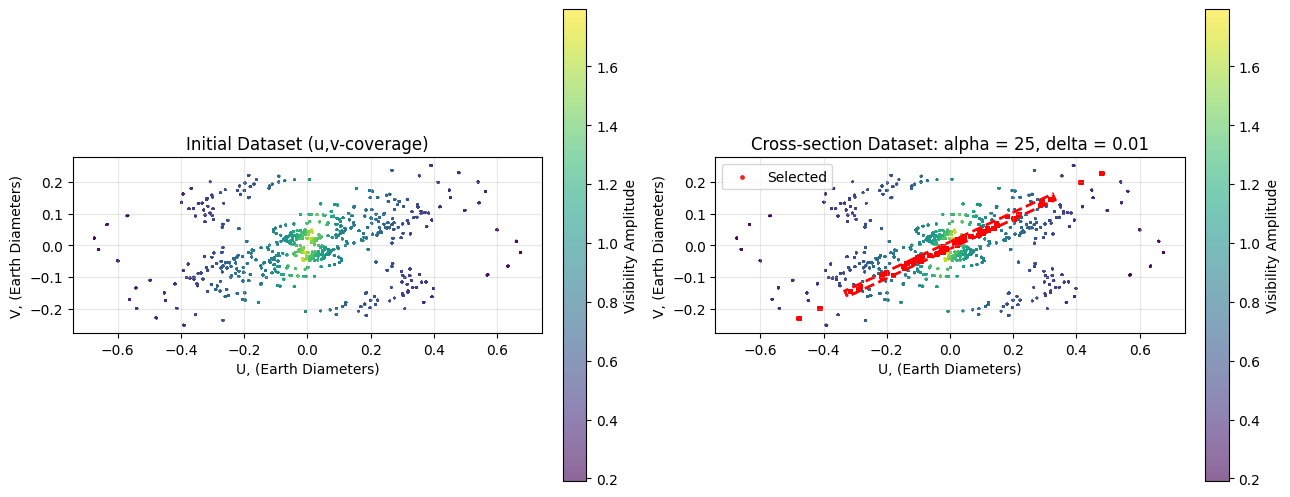

In [218]:
plot_uv_coverage(
    dataset=dataset_m87,
    alpha_test=alpha_test,
    delta_test=delta_test,
    amplitude_col='Amplitude',
    u_col='U',
    v_col='V',
    figsize=(13, 6),
    point_size=3,
    alpha_val=0.6,
    cmap='viridis',
    selected_color='red'
);

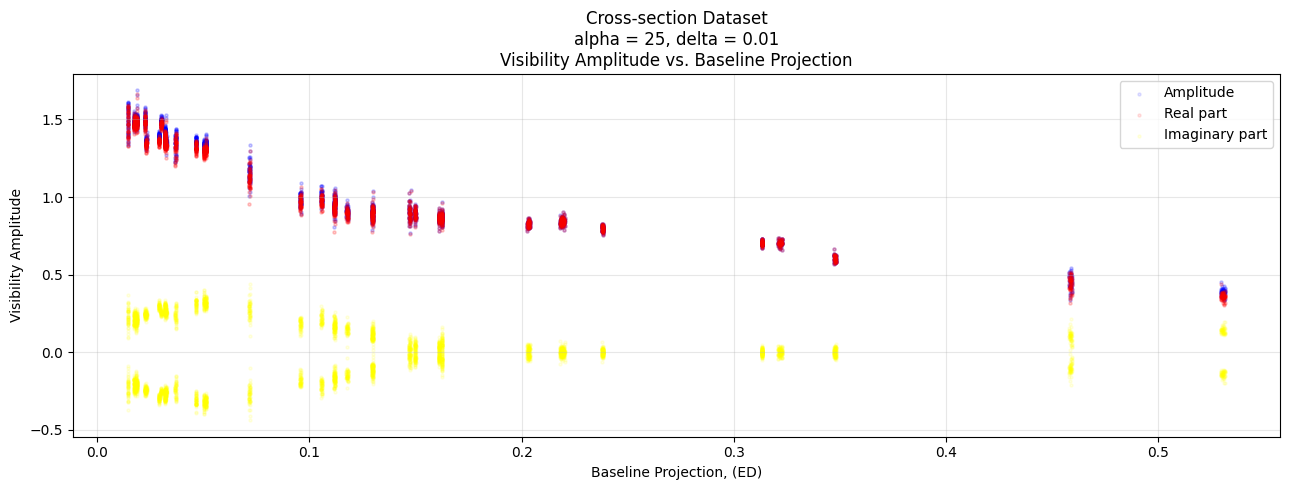

In [219]:
plot_visibility_components(
    filtered_data=filtered_data,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    real_col='Re',
    imag_col='Im',
    alpha=0.1,
    size=5,
    amplitude_color='blue',
    real_color='red',
    imag_color='yellow',
    figsize=(13, 5),
    xlabel='Baseline Projection, (ED)',
    ylabel='Visibility Amplitude',
    title_prefix='Cross-section Dataset',
    alpha_test=alpha_test,
    delta_test=delta_test,
    grid=True
);

## Data Prepartion

In [220]:
selected_data, rest_data, used_ranges = select_by_baseline_ranges(
    dataset=filtered_data,
    baseline_col='Baseline',
    ranges=[(0.1, 0.2), (0.5, 0.6), (0.7, 0.8)],
    mode='specified'
)

Mode: specified
Selected baseline ranges: [(0.1, 0.2), (0.5, 0.6), (0.7, 0.8)]
Points selected: 1,280 from 4,234 (30.2%)
Selected range sizes: [0.1, 0.09999999999999998, 0.10000000000000009]


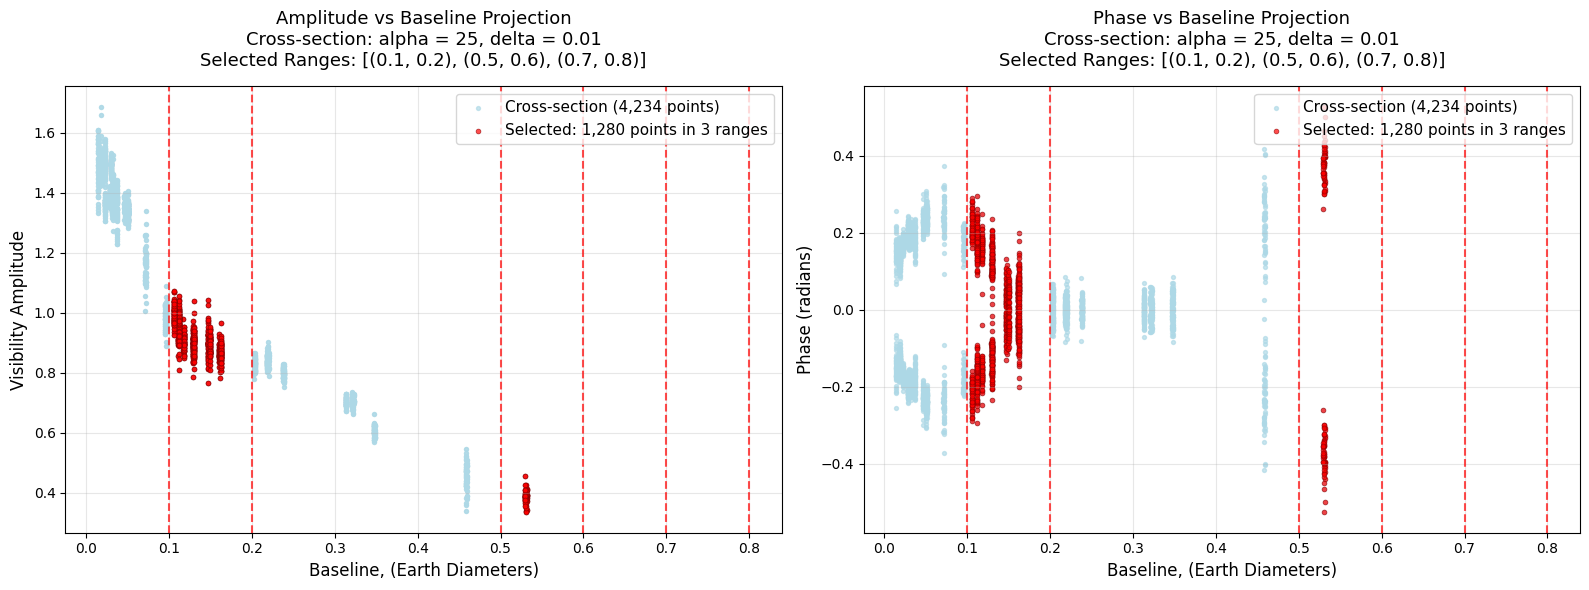

In [222]:
plot_amplitude_phase_with_selection(
    filtered_data, selected_data, used_ranges,
    alpha_test=alpha_test, delta_test=delta_test
);

**Comment**: next step is to prepare the dataset for further training, validation and testing of the model.

In [223]:
rest_data = rest_data.sort_values('Baseline').reset_index(drop=True)

X_data = rest_data[['U', 'V', 'Baseline']].values
y_data = rest_data[['Re', 'Im']].values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_data)

X_tensor = torch.from_numpy(X_scaled).float()
y_tensor = torch.from_numpy(y_scaled).float()

In [224]:
# creating initial dataset
dataset_model = create_dataset_from_data(X_tensor, y_tensor, train_ratio=1-TEST_SIZE, device=device)

In [225]:
print("Training dataset input features dimensions:", dataset_model['train_input'].shape)
print("Training dataset target features dimensions:", dataset_model['train_label'].shape)
print("Validation dataset input features dimensions:", dataset_model['test_input'].shape)
print("Validation dataset target features dimensions:", dataset_model['test_label'].shape)

Training dataset input features dimensions: torch.Size([2067, 3])
Training dataset target features dimensions: torch.Size([2067, 2])
Validation dataset input features dimensions: torch.Size([887, 3])
Validation dataset target features dimensions: torch.Size([887, 2])


## Model Initialization

In [226]:
# initialize model
model = KAN(width=[3, 12, 12, 2],
            grid=5,
            k=3,
            seed=RANDOM_STATE,
            device=device)


checkpoint directory created: ./model
saving model version 0.0


## Training

In [227]:
history = model.fit(dataset_model,
                    opt="LBFGS",
                    steps=1000,
                    update_grid=True);

| train_loss: 1.14e-01 | test_loss: 1.09e-01 | reg: 5.95e+01 | : 100%|█| 1000/1000 [13:14<00:00,  1.

saving model version 0.1


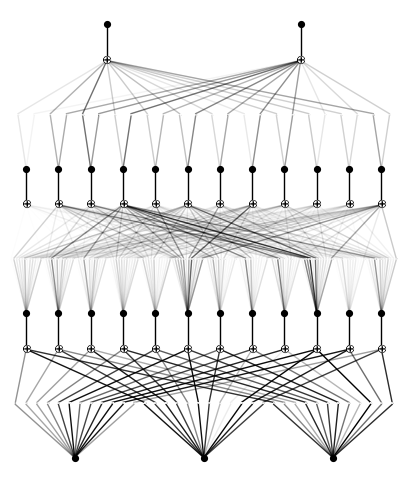

In [228]:
model.plot()

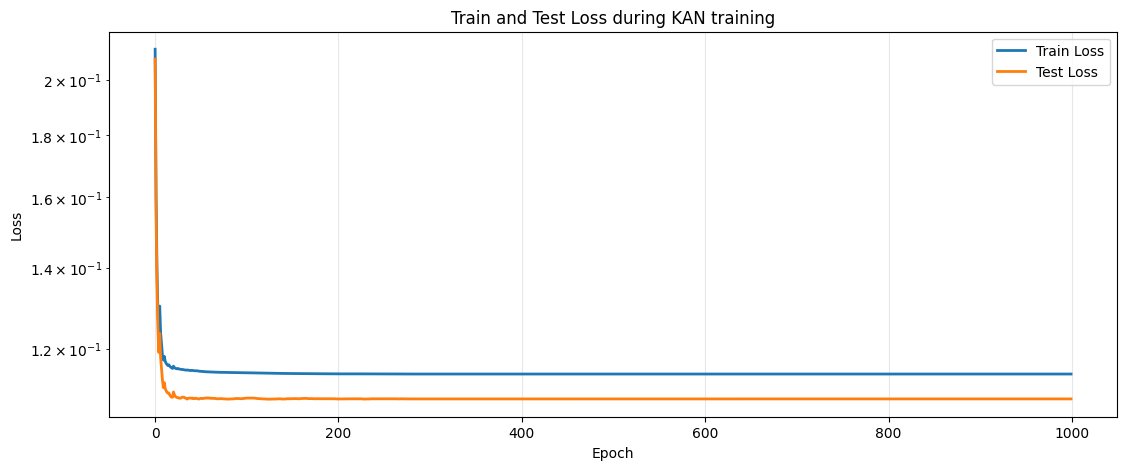

In [229]:
plt.figure(figsize=(13, 5))
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss during KAN training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

## Testing

### Selected Ranges

In [230]:
test_data_raw = selected_data[['U', 'V', 'Baseline']].values
test_data_scaled = scaler_X.transform(test_data_raw)
test_data = torch.from_numpy(test_data_scaled).float()

In [231]:
results_scaled = model(test_data)

In [232]:
results_denormalized = scaler_y.inverse_transform(results_scaled.detach().numpy())
results_amplitude = np.sqrt(results_denormalized[:, 0]**2 + results_denormalized[:, 1]**2)
results_phase = np.arctan2(results_denormalized[:, 1], results_denormalized[:, 0])

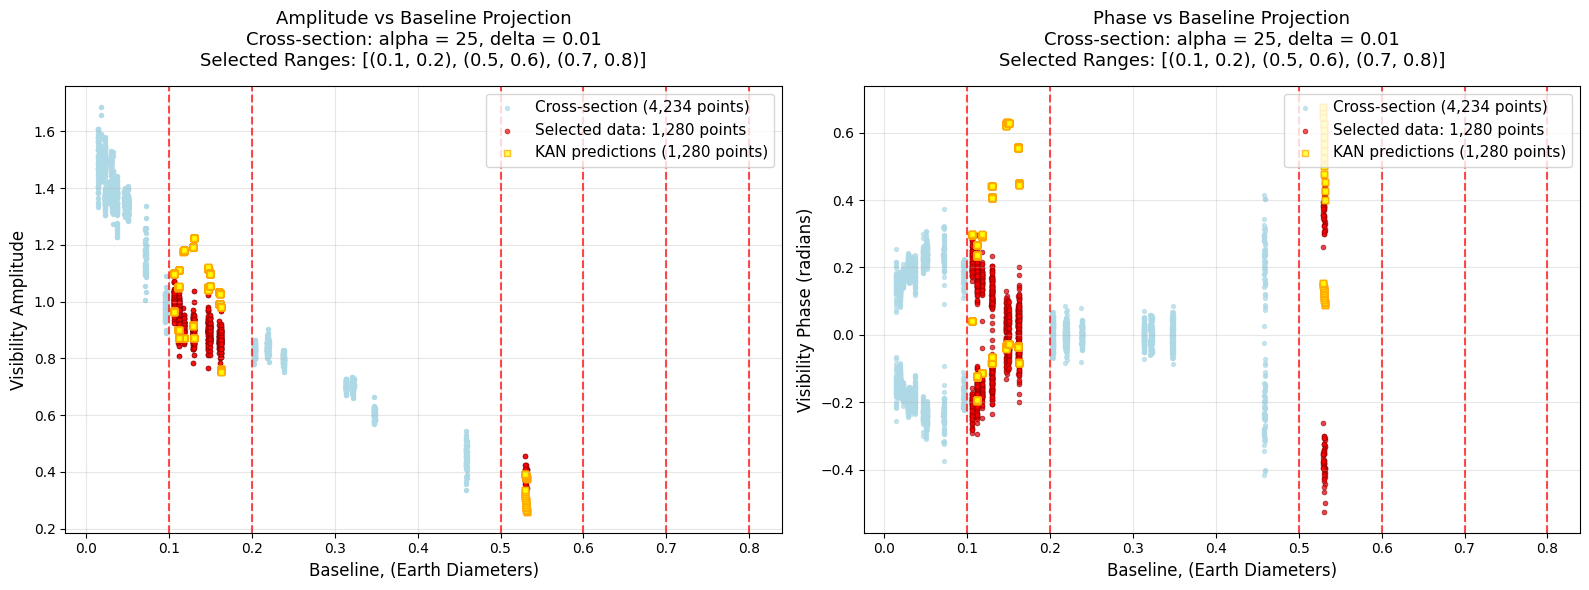

In [233]:
fig, axs = plot_predictions_comparison(
    filtered_data, selected_data, results_amplitude, results_phase, used_ranges,
    alpha_test=alpha_test, delta_test=delta_test
)

### Whole Dataset

In [234]:
whole_data_raw = filtered_data[['U', 'V', 'Baseline']].values
whole_data_scaled = scaler_X.transform(whole_data_raw)
whole_data = torch.from_numpy(whole_data_scaled).float()

In [235]:
results_whole_scaled = model(whole_data)

In [236]:
results_whole_denormalized = scaler_y.inverse_transform(results_whole_scaled.detach().numpy())
results_whole = np.sqrt(results_whole_denormalized[:, 0]**2 + results_whole_denormalized[:, 1]**2)
results_phase_whole = np.arctan2(results_whole_denormalized[:, 1], results_whole_denormalized[:, 0])

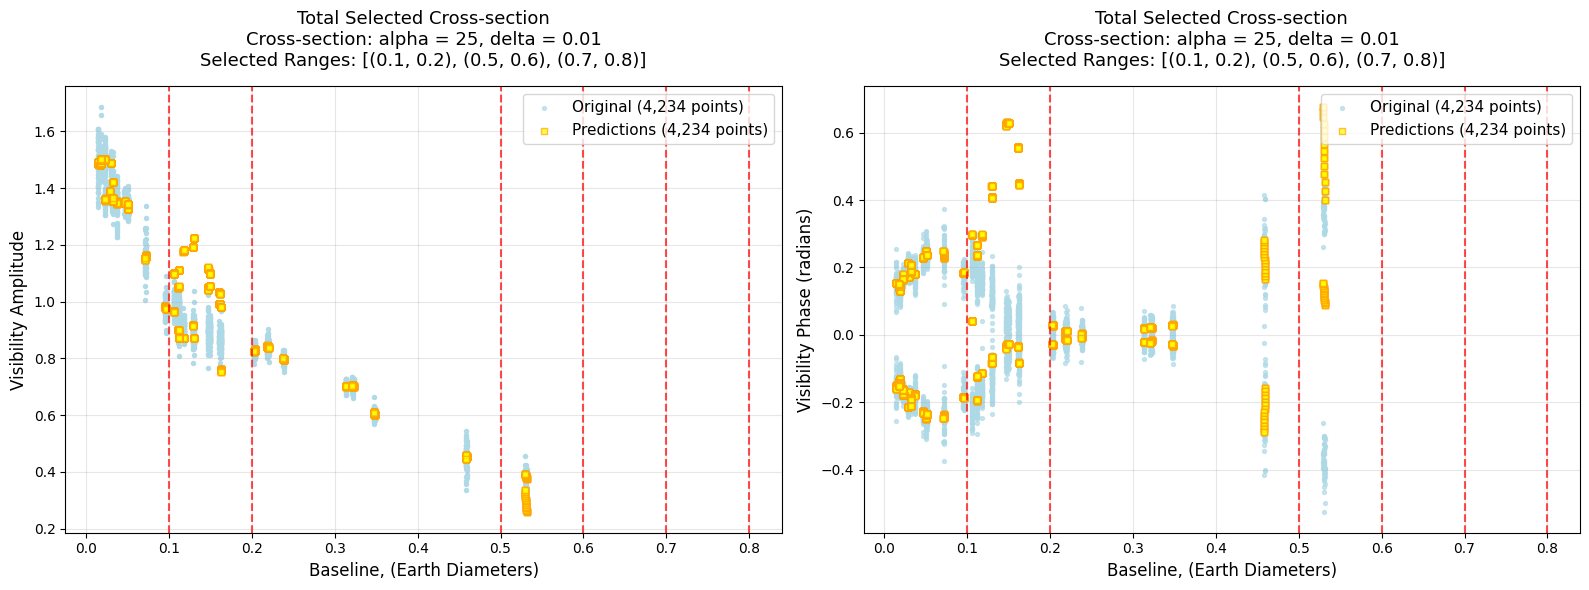

In [237]:
fig, axs = plot_whole_predictions(
    filtered_data, results_whole, results_phase_whole, used_ranges,
    alpha_test=alpha_test, delta_test=delta_test
)

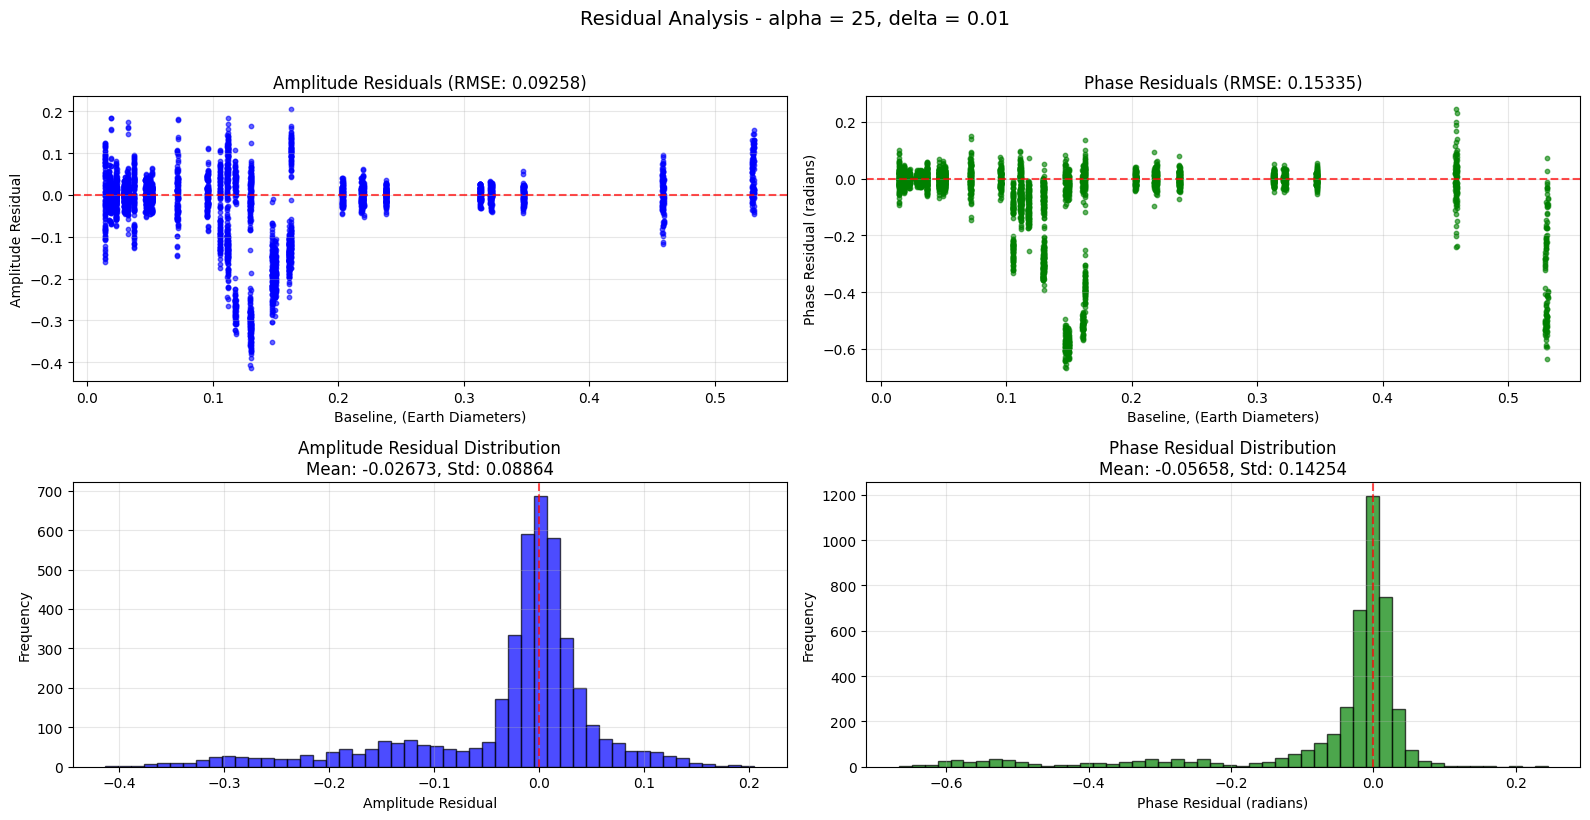

Residuals statistics:

Amplitude:
- RMSE: 0.09258
- MAE: 0.05526
- Mean residual: -0.02673
- Std residual: 0.08864

Phase:
- RMSE: 0.15335
- MAE: 0.07135
- Mean residual: -0.05658
- Std residual: 0.14254


In [238]:
fig, stats = plot_residuals_analysis(
    filtered_data=filtered_data,
    results_amplitude=results_whole,
    results_phase=results_phase_whole,
    baseline_col='Baseline',
    amplitude_col='Amplitude',
    phase_col='Phase',
    alpha_test=alpha_test,
    delta_test=delta_test,
    figsize=(16, 8),
    return_stats=True
)

## Full Dataset Span Training for Interpolation

### Data Preparation

In [239]:
filtered_data = filtered_data.sort_values('Baseline').reset_index(drop=True)

X_data = filtered_data[['U', 'V', 'Baseline']].values
y_data = filtered_data[['Re', 'Im']].values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_data)

X_tensor = torch.from_numpy(X_scaled).float()
y_tensor = torch.from_numpy(y_scaled).float()

In [240]:
# creating initial dataset
dataset_model = create_dataset_from_data(X_tensor, y_tensor, train_ratio=1-TEST_SIZE, device=device)

### Model Initialization

In [241]:
# initialize model
model = KAN(width=[3, 12, 12, 2],
            grid=5,
            k=3,
            seed=RANDOM_STATE,
            device=device)


checkpoint directory created: ./model
saving model version 0.0


### Training

In [242]:
history = model.fit(dataset_model,
                    opt="LBFGS",
                    steps=1000,
                    update_grid=True);

| train_loss: 1.24e-01 | test_loss: 1.30e-01 | reg: 6.11e+01 | : 100%|█| 1000/1000 [23:15<00:00,  1.

saving model version 0.1


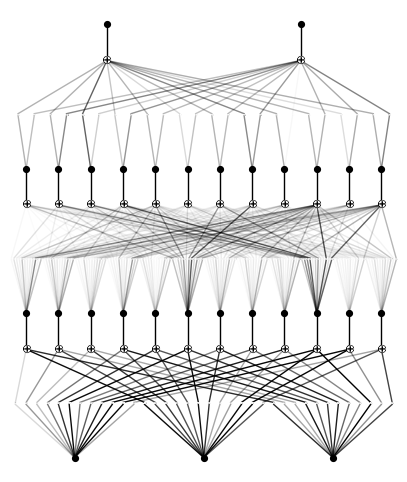

In [243]:
model.plot()

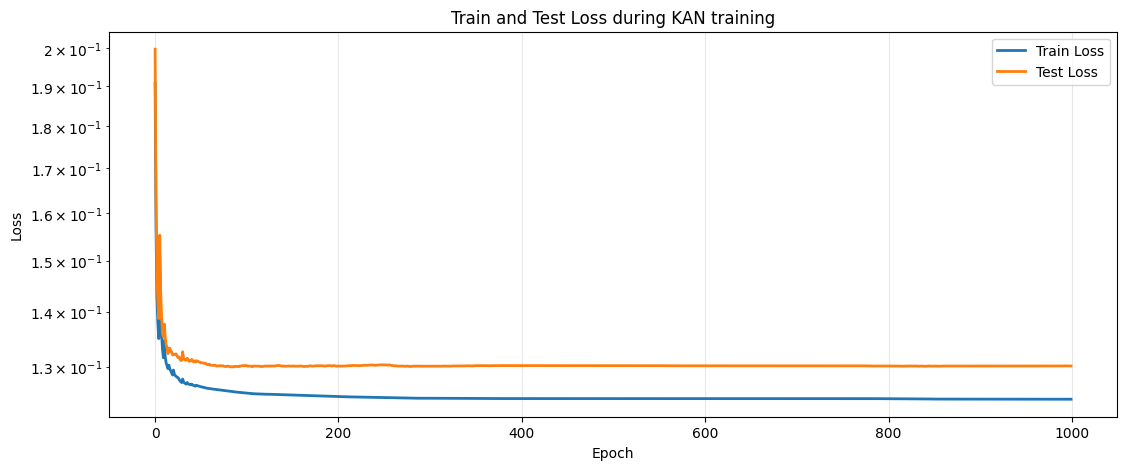

In [244]:
plt.figure(figsize=(13, 5))
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss during KAN training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

### Testing

Initial Data Dimensions: (4234, 7)
Generated Test Data Dimensions: (851, 3)
U range: [-0.4796, 0.4796], шаг: 0.005
V range: [-0.2300, 0.2300], шаг: 0.005
Number of test points: 851


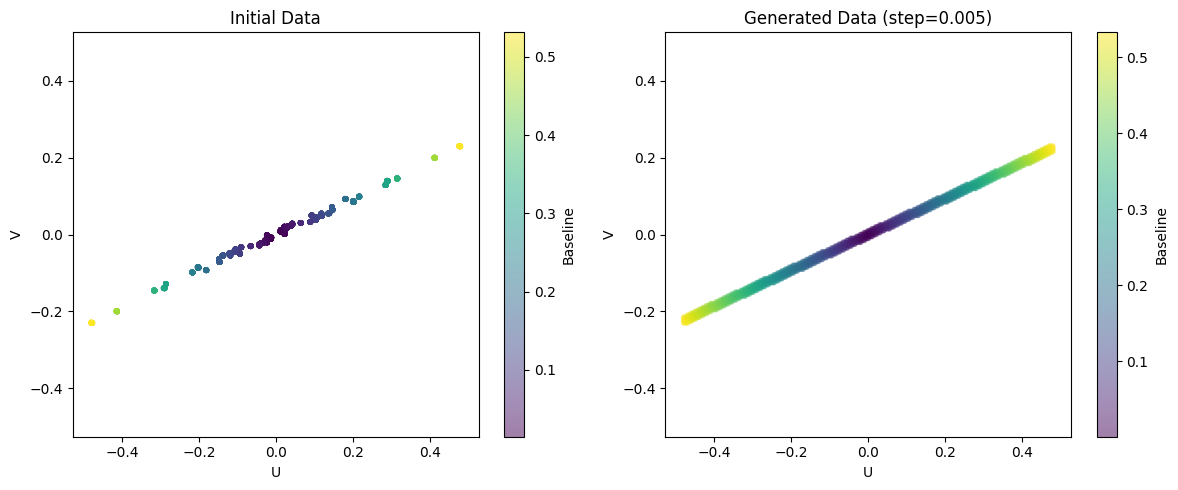

In [245]:
u_min = filtered_data['U'].min()
u_max = filtered_data['U'].max()
v_min = filtered_data['V'].min()
v_max = filtered_data['V'].max()

step = 0.005
u_values = np.arange(u_min, u_max + step/2, step)
v_values = np.arange(v_min, v_max + step/2, step)


U_grid, V_grid = np.meshgrid(u_values, v_values)
Baseline_grid = np.sqrt(U_grid**2 + V_grid**2)

alpha = np.radians(alpha_test)
distance = np.abs(U_grid * np.sin(alpha) - V_grid * np.cos(alpha))

mask_cross_section = distance <= delta_test
mask = mask_cross_section

U_filtered = U_grid[mask]
V_filtered = V_grid[mask]
Baseline_filtered = Baseline_grid[mask]

test_data_raw = np.column_stack([U_filtered, V_filtered, Baseline_filtered])

print(f"Initial Data Dimensions: {filtered_data.shape}")
print(f"Generated Test Data Dimensions: {test_data_raw.shape}")
print(f"U range: [{u_min:.4f}, {u_max:.4f}], шаг: {step}")
print(f"V range: [{v_min:.4f}, {v_max:.4f}], шаг: {step}")
print(f"Number of test points: {len(test_data_raw)}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(filtered_data['U'], filtered_data['V'], 
           c=filtered_data['Baseline'], alpha=0.5, s=10, cmap='viridis')
plt.xlabel('U')
plt.ylabel('V')
plt.title('Initial Data')
plt.colorbar(label='Baseline')
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(test_data_raw[:, 0], test_data_raw[:, 1], 
           c=test_data_raw[:, 2], alpha=0.5, s=10, cmap='viridis')
plt.xlabel('U')
plt.ylabel('V')
plt.title(f'Generated Data (step={step})')
plt.colorbar(label='Baseline')
plt.axis('equal')

plt.tight_layout()
plt.show()

In [246]:
test_data_scaled = scaler_X.transform(test_data_raw)
test_data = torch.from_numpy(test_data_scaled).float()

In [247]:
results_scaled = model(test_data)

In [248]:
print(f"Размер test_data_raw[:, 2]: {test_data_raw[:, 2].shape}")
print(f"Размер results_amplitude: {results_amplitude.shape}")

Размер test_data_raw[:, 2]: (851,)
Размер results_amplitude: (1280,)


In [249]:
results_denormalized = scaler_y.inverse_transform(results_scaled.detach().numpy())
results_amplitude = np.sqrt(results_denormalized[:, 0]**2 + results_denormalized[:, 1]**2)
results_phase = np.arctan2(results_denormalized[:, 1], results_denormalized[:, 0])

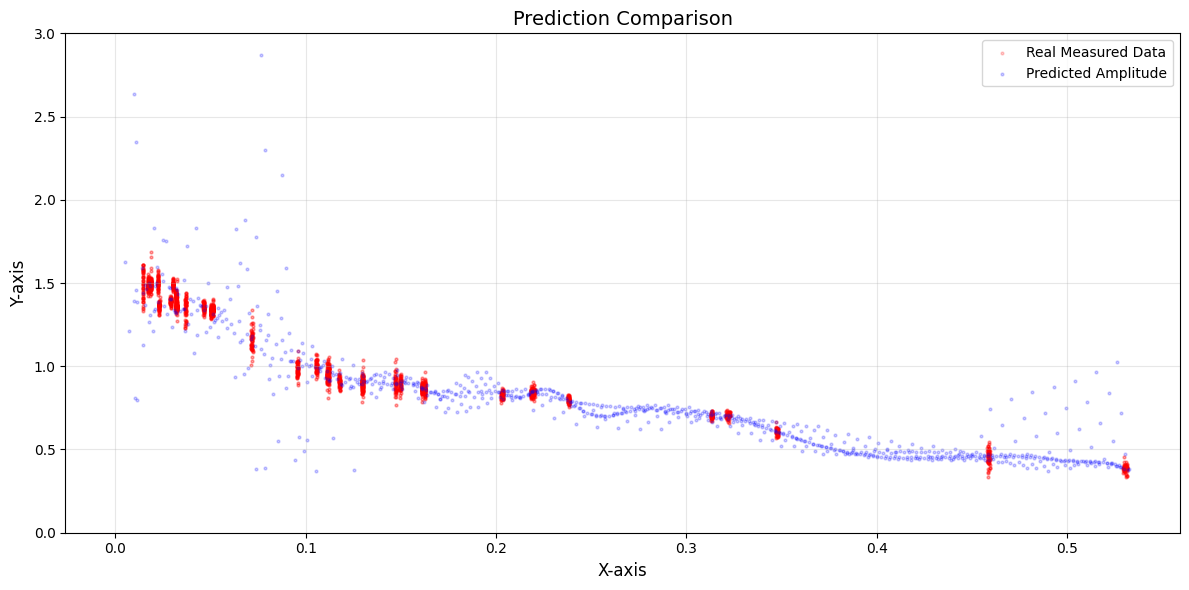

In [254]:
plt.figure(figsize=(12, 6))

plt.scatter(filtered_data['Baseline'], filtered_data['Amplitude'], 
           color='red', alpha=0.2, s=4, label='Real Measured Data')
plt.scatter(test_data_raw[:, 2], results_amplitude, 
           color='blue', alpha=0.2, s=4, label='Predicted Amplitude')


plt.xlabel('X-axis', fontsize=12)
plt.ylabel('Y-axis', fontsize=12)
plt.ylim(0, 3)
plt.title('Prediction Comparison', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

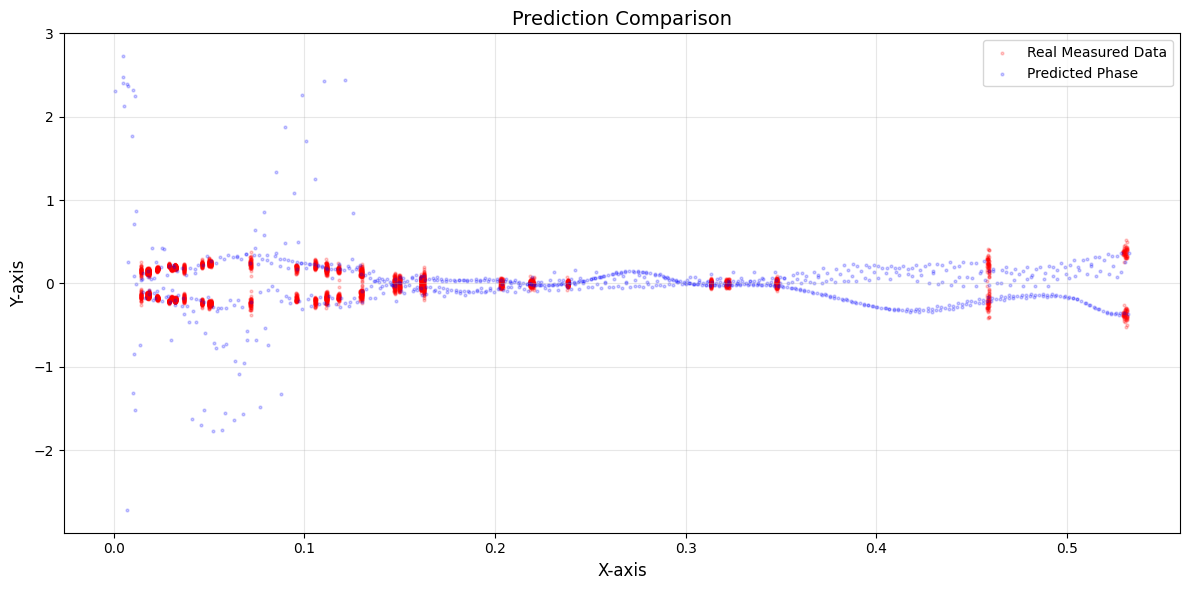

In [251]:
plt.figure(figsize=(12, 6))

plt.scatter(filtered_data['Baseline'], filtered_data['Phase'], 
           color='red', alpha=0.2, s=4, label='Real Measured Data')
plt.scatter(test_data_raw[:, 2], results_phase, 
           color='blue', alpha=0.2, s=4, label='Predicted Phase')


plt.xlabel('X-axis', fontsize=12)
plt.ylabel('Y-axis', fontsize=12)
plt.title('Prediction Comparison', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Results and Discussions